**Final Project Submission**

Please fill out:
* Student name: Braydon Charles Janecek
* Student pace: Full-time
* Scheduled project review date/time: TBD
* Instructor name: Abhineet
* Blog post URL: TBD


In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
import pickle
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

from helper import *

# Network Intrusion Detection System Overview

## The Threat of Network Intrusion to Businesses

Network security is a very serious matter in modern times. In fact, statistics show that at least 64% of companies have experienced web-based attacks. The average data breach cost is expected to exceed 150 billion USD in 2020 and most companies will take around six months to even realize that they've been hacked. While small businesses may think their safe they are actually the target around 43% of the time. 

An intrusion detection system (ISD) is a software application which monitors incoming network traffic for malicious activity. The goal of this project was to create a network intrusion detection system capable of thwarting future attacks. 

## The Objective and Data

The dataset used to build our network detection system comes from the 1998 DARPA Intrusion Detection Evaluation Program prepared and managed by MIT Lincoln Labs. The data included a wide variety of intrusions along with normal connections simulated in a military network environment. 

A connection is a sequence of TCP packets between which data flows between a source IP address and a target IP address. These conenctions may be either normal connections or cybersecurity threats. Out dataset had four broad categories of threats. 

1. Denial of Service (DoS) - a DoS attack is an attack in which the perpetrator floods a machine or network with requests to the point where legitimate requests are unable to be processed. 
2. User-to-root (U2R) - a U2R attack is an attack in which the perpetrator uses a legitimate user account (guessed password) and uses a vulnerability to gain root access. 
3. Probe - a probe is an attack in which the perpetrator seeks to gain information about a network of computers with the sole purpose of finding security vulnerabilities. 
4. Remote-to-local (R2L) - a R2L attack occurs when the perpetrator has the ability to send packets to a machine over a network (but without an account on that machine) exploits a vulerability to gain user access to that machine. 

What makes this dataset more interesting is that the test dataset contains several different attacks which were not seen in the training data. This could potentially show which classification algorithms may be better generalized to new attacks. "Some intrusion experts believe that most novel attacks are variants of known attacks and the "signature" of known attacks can be sufficient to catch novel variants." The training dataset contains a total of 24 training attack types, with an additional 14 types in the test data only.

At this point we will note that twenty years later this dataset is outdated and does not accurately represent modern day network traffic or threats. Nevertheless, it is still the largest fully-labelled intrusion dataset available and is a good exercise. 

## Features 

The features associated with this dataset are desribed below. Please note that some of these features have been engineered by cybersecurity experts. It is unlikely a data scientist without network security domain knowledge would know to engiener these features, however, if working on this project with domain experts these features would likely be suggested. 

<img src="feature_descriptions.png">

# Data Cleaning and EDA

Time to get cranking data wrangling! Here we'll import our training dataset, check the datatypes, check the shape of the data, and see if we have any missing values. 

## Initial Data Overview 

In [619]:
# import data
df = pd.read_csv('kddcup99_csv.csv')

In [5]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [6]:
# check number of features and connections
df.shape

(494020, 42)

In [7]:
# check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
duration                       494020 non-null int64
protocol_type                  494020 non-null object
service                        494020 non-null object
flag                           494020 non-null object
src_bytes                      494020 non-null int64
dst_bytes                      494020 non-null int64
land                           494020 non-null int64
wrong_fragment                 494020 non-null int64
urgent                         494020 non-null int64
hot                            494020 non-null int64
num_failed_logins              494020 non-null int64
logged_in                      494020 non-null int64
lnum_compromised               494020 non-null int64
lroot_shell                    494020 non-null int64
lsu_attempted                  494020 non-null int64
lnum_root                      494020 non-null int64
lnum_file_creations            494020 

In [8]:
# finally let's check the normalized frequency of various values across all columns
for col in df.columns:
    print(col, '\n', df[col].value_counts(normalize=True).head(10), '\n\n')

duration 
 0       0.975001
1       0.005012
2       0.001761
3       0.001265
5       0.001121
2630    0.001004
4       0.000836
14      0.000652
10      0.000393
7       0.000342
Name: duration, dtype: float64 


protocol_type 
 icmp    0.574070
tcp     0.384729
udp     0.041201
Name: protocol_type, dtype: float64 


service 
 ecr_i       0.569613
private     0.224471
http        0.130140
smtp        0.019681
other       0.014649
domain_u    0.011868
ftp_data    0.009556
eco_i       0.003324
ftp         0.001615
finger      0.001356
Name: service, dtype: float64 


flag 
 SF        0.766040
S0        0.176120
REJ       0.054401
RSTR      0.001828
RSTO      0.001172
SH        0.000217
S1        0.000115
S2        0.000049
RSTOS0    0.000022
S3        0.000020
Name: flag, dtype: float64 


src_bytes 
 1032     0.461591
0        0.233476
520      0.106826
105      0.014918
147      0.005516
54540    0.004338
146      0.004115
42       0.002164
8        0.002115
28       0.001992
Name: s

Because we are treating this problem as a binary classification problem, we will re-label the labels as either 0 for normal connections or 1 for attacks. 

In [9]:
print("Number of unique labels: {}".format(df['label'].nunique()))
df['label'].value_counts()

Number of unique labels: 23


smurf              280790
neptune            107201
normal              97277
back                 2203
satan                1589
ipsweep              1247
portsweep            1040
warezclient          1020
teardrop              979
pod                   264
nmap                  231
guess_passwd           53
buffer_overflow        30
land                   21
warezmaster            20
imap                   12
rootkit                10
loadmodule              9
ftp_write               8
multihop                7
phf                     4
perl                    3
spy                     2
Name: label, dtype: int64

In [17]:
df['target'] = df['label'].apply(lambda x: 0 if x=='normal' else 1)

In [11]:
df['target'].value_counts()

1    396743
0     97277
Name: target, dtype: int64

In the future we will certainly be interested in determining which types of attacks our intrusion detection system is most effective at detecting. Therefore, we will create a new column which specifies the attack type. 

In [620]:
# define function to classify attack type 
def attack_type(x):
    if x in ('back', 'land', 'smurf', 'pod', 'neptune'):
        attack_type = 'DOS'
    elif x in ('ipsweep', 'portsweep', 'nmap', 'satan'):
        attack_type = 'Probe'
    elif x in ('loadmodule', 'rootkit', 'perl', 'buffer_overflow'):
        attack_type = 'U2R'
    elif x in ('normal'):
        attack_type = 'NA'
    else:
        attack_type = 'R2L'
    return attack_type

In [621]:
# apply function to dataframe
df['attack_type'] = df['label'].apply(attack_type)

In [622]:
# check out distribution
df['attack_type'].value_counts(normalize=True)

DOS      0.790411
NA       0.196909
Probe    0.008313
R2L      0.004261
U2R      0.000105
Name: attack_type, dtype: float64

As we can see our training data is heaviliy skewed towards DOS attack types. We will note that this may cause a problem when trying to classify probe, R2L or U2R attacks and will investigate this further later in this notebook. 

Now let's take a closer look at our three categorical variables which will require one hot encoding. 

In [15]:
# 66 unique features, of which 3 (ecr_i, private, and http) make up the majority (92%abs)
df['service'].value_counts(normalize=True)

ecr_i      0.569613
private    0.224471
http       0.130140
smtp       0.019681
other      0.014649
             ...   
X11        0.000022
tim_i      0.000014
pm_dump    0.000002
tftp_u     0.000002
red_i      0.000002
Name: service, Length: 66, dtype: float64

In [16]:
# 3 unique features with heavy skew towards icmp and tcp 
df['protocol_type'].value_counts(normalize=True)

icmp    0.574070
tcp     0.384729
udp     0.041201
Name: protocol_type, dtype: float64

In [17]:
# 11 unique features with heavy skew towards 
df['flag'].value_counts(normalize=True)

SF        0.766040
S0        0.176120
REJ       0.054401
RSTR      0.001828
RSTO      0.001172
SH        0.000217
S1        0.000115
S2        0.000049
RSTOS0    0.000022
S3        0.000020
OTH       0.000016
Name: flag, dtype: float64

## Exploring Features and Correlations

We'd now like to begin exploring our target variable and its relationship with our various features.  

In [18]:
# def categorical features and continuous features
cat_features = df[['protocol_type', 'service', 'flag']]
cont_features = df.drop(['protocol_type', 'service', 'flag', 'target', 'label', 'attack_type'], axis=1)

### Categorical Features

#### Service

Given it has sixty-six unique values, the 'service' feature is likely to be the most time consuming to visualize effectively. Here we will do our best with that.

In [19]:
# sum number of attacks for each service type in new dataframe
services = df[['service', 'target']]
total_attacks_per_service = services.groupby('service').sum()
# count total number of service occurences by type and add to new df
total_attacks_per_service['total_service_occurences'] = services.groupby('service').count()
# reset index to make 'service' a column
total_attacks_per_service = total_attacks_per_service.reset_index()
# set columns names
total_attacks_per_service.columns = ['service', 'sum_attacks', 'sum_service_occurences']
total_attacks_per_service

,service,sum_attacks,sum_service_occurences
0,IRC,1,43
1,X11,2,11
2,Z39_50,92,92
3,auth,108,328
4,bgp,106,106
...,...,...,...
61,urp_i,1,538
62,uucp,106,106
63,uucp_path,106,106
64,vmnet,106,106


In [20]:
# create new column to calculate percentage of service occurences which were attacks
total_attacks_per_service['percent_attack'] = total_attacks_per_service.apply(lambda row: row['sum_attacks']/row['sum_service_occurences']*100, axis=1)

In [21]:
# sort by occurence
total_attacks_per_service = total_attacks_per_service.sort_values(by='percent_attack', ascending=False)
total_attacks_per_service

,service,sum_attacks,sum_service_occurences,percent_attack
33,netbios_dgm,99,99,100.000000
41,pm_dump,1,1,100.000000
28,ldap,101,101,100.000000
29,link,102,102,100.000000
30,login,104,104,100.000000
...,...,...,...,...
11,domain_u,1,5863,0.017056
57,tftp_u,0,1,0.000000
60,urh_i,0,14,0.000000
39,ntp_u,0,380,0.000000


In [22]:
# let's see how many services are related to attacks 100% of the time in our training data
len(total_attacks_per_service[total_attacks_per_service['percent_attack'] == 100])

41

So our training data shows that for forty-one out of sixty-six services are correlated with attacks 100% of the time. Four out of sixty-six yielded attacks 0% of the time. The service types which yielded an attack 100% of the time are listed below. We will visualize the remaining seventeen services. 

In [23]:
# these are the names of the services which always yield an attack
service_always_attack = list(total_attacks_per_service[total_attacks_per_service['percent_attack'] == 100]['service'])
service_always_attack

['netbios_dgm',
 'pm_dump',
 'ldap',
 'link',
 'login',
 'mtp',
 'name',
 'netbios_ns',
 'netbios_ssn',
 'netstat',
 'nnsp',
 'nntp',
 'pop_2',
 'klogin',
 'printer',
 'remote_job',
 'rje',
 'sql_net',
 'sunrpc',
 'supdup',
 'systat',
 'uucp',
 'uucp_path',
 'vmnet',
 'kshell',
 'whois',
 'iso_tsap',
 'efs',
 'courier',
 'csnet_ns',
 'ctf',
 'daytime',
 'bgp',
 'discard',
 'imap4',
 'Z39_50',
 'echo',
 'exec',
 'http_443',
 'hostnames',
 'gopher']

Finally we can plot this dataframe to visualize percent of attack occurences by each service type. 

In [24]:
# we'll create a temp df with only services that do not yield attack 100% of the time in our training data
temp_df = total_attacks_per_service[total_attacks_per_service['percent_attack'] < 100]
temp_df

,service,sum_attacks,sum_service_occurences,percent_attack
14,ecr_i,281055,281400,99.877399
49,shell,111,112,99.107143
52,ssh,104,105,99.047619
10,domain,113,116,97.413793
45,private,103527,110893,93.357561
13,eco_i,1253,1642,76.309379
58,tim_i,5,7,71.428571
59,time,105,157,66.878981
43,pop_3,123,202,60.891089
56,telnet,294,513,57.309942


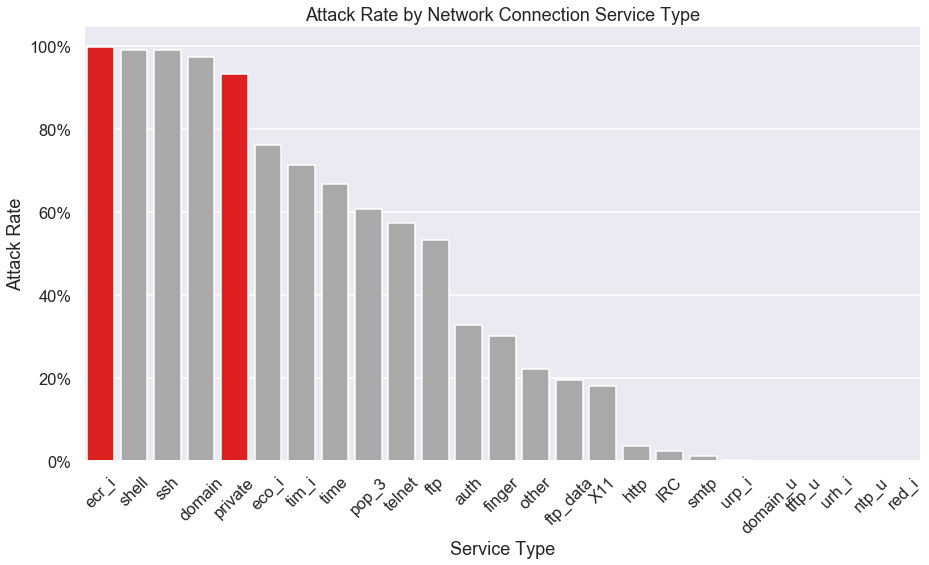

In [25]:
# set plot size
plt.figure(figsize=(15,8))

# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# create color palette
my_pal = {service: "r" if service == 'ecr_i' or 
                          service == 'private' else "darkgrey" for service in temp_df.service.unique()} 

# initialize barplot in seaborn
ax = sns.barplot(x='service', y='percent_attack', data=temp_df, palette=my_pal)

# create labels to feed x axis
labels = temp_df['service'].unique()
ax.set_xticklabels(labels=labels, rotation=45)

# set title and labels
plt.title("Attack Rate by Network Connection Service Type")
plt.xlabel("Service Type")
plt.ylabel("Attack Rate")

# format y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [26]:
# let's see the total number of attacks
sum(total_attacks_per_service['sum_attacks'])

396743

In [27]:
# sum attacks from ecr_i and private services
sum(total_attacks_per_service[(total_attacks_per_service['service'] == "ecr_i") | 
                              (total_attacks_per_service['service'] == "private")]['sum_attacks'])

384582

In [28]:
# let's see the total number of benign connections
len(df) - sum(total_attacks_per_service['sum_attacks'])

97277

In [29]:
# sum attacks from ecr_i and private services
sum(total_attacks_per_service[(total_attacks_per_service['service'] == "ecr_i") | 
                              (total_attacks_per_service['service'] == "private")]['sum_attacks'])

384582

We can make the following inferences using the data above:
1. ecr_i and private services make up 281,055 and 103,527 connections (384,582 combined), respectively, out of our total 396,743 connections classified as attacks. ecr_i and private services types are shown to be attacks 99.9% and 93.4% of the time, respectively. Connections coming from these types of services should be immediately flagged in a network intrusion detection system and reviewed by a security analyst. 
2. Services found in the 'service_always_attack' list should be further investigated and determine if there any legitimate uses to these service types. 

#### Protocol Type

In [30]:
# sum number of attacks for each protocol type in new dataframe
protocols = df[['protocol_type', 'target']]
total_attacks_per_protocol = protocols.groupby('protocol_type').sum()
# count total number of protocol occurences by type and add to new df
total_attacks_per_protocol['total_protocol_occurences'] = protocols.groupby('protocol_type').count()
# reset index to make 'protocol' a column
total_attacks_per_protocol = total_attacks_per_protocol.reset_index()
# set columns names
total_attacks_per_protocol.columns = ['protocol', 'sum_attacks', 'sum_protocol_occurences']
total_attacks_per_protocol

,protocol,sum_attacks,sum_protocol_occurences
0,icmp,282314,283602
1,tcp,113252,190064
2,udp,1177,20354


In [31]:
# create new column to calculate percentage of protocol occurences which were attacks
total_attacks_per_protocol['percent_attack'] = total_attacks_per_protocol.apply(lambda row: row['sum_attacks']/row['sum_protocol_occurences']*100, axis=1)

In [32]:
# sort by occurence
total_attacks_per_protocol = total_attacks_per_protocol.sort_values(by='percent_attack', ascending=False)
total_attacks_per_protocol

,protocol,sum_attacks,sum_protocol_occurences,percent_attack
0,icmp,282314,283602,99.545842
1,tcp,113252,190064,59.586245
2,udp,1177,20354,5.782647


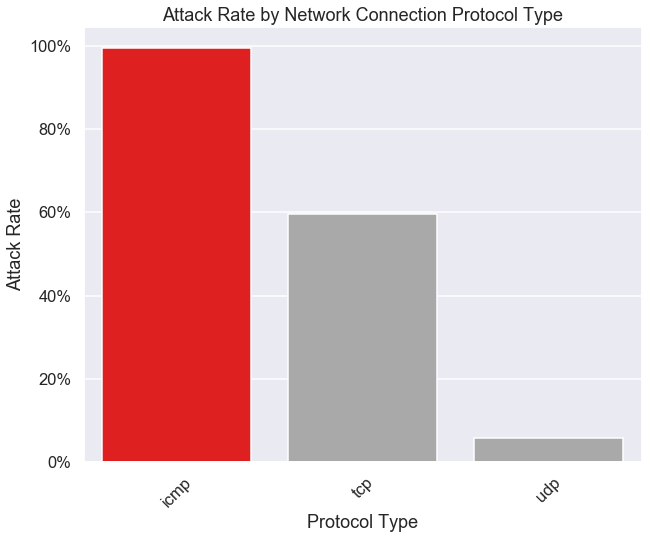

In [33]:
# set plot size
plt.figure(figsize=(10,8))

# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# create color palette
my_pal = {protocol: "r" if protocol == 'icmp' 
                       else "darkgrey" for protocol in total_attacks_per_protocol.protocol.unique()} 

# initialize barplot in seaborn
ax = sns.barplot(x='protocol', y='percent_attack', data=total_attacks_per_protocol, palette=my_pal)

# create labels to feed x axis
labels = total_attacks_per_protocol['protocol'].unique()
ax.set_xticklabels(labels=labels, rotation=45)

# set title and labels
plt.title("Attack Rate by Network Connection Protocol Type")
plt.xlabel("Protocol Type")
plt.ylabel("Attack Rate")

# format y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

We can infer from the above, that icmp protocol types are frequently associated with attacks with approximately a 99.5% attack rate. Furthermore, this is the most frequent protocol type with 283,602 occurences out of the total 494,020 attacks. 

#### Flag

In [34]:
# sum number of attacks for each flag type in new dataframe
flags = df[['flag', 'target']]
total_attacks_per_flag = flags.groupby('flag').sum()
# count total number of flag occurences by type and add to new df
total_attacks_per_flag['total_flag_occurences'] = flags.groupby('flag').count()
# reset index to make 'flag' a column
total_attacks_per_flag = total_attacks_per_flag.reset_index()
# set columns names
total_attacks_per_flag.columns = ['flag', 'sum_attacks', 'sum_flag_occurences']
total_attacks_per_flag

,flag,sum_attacks,sum_flag_occurences
0,OTH,7,8
1,REJ,21534,26875
2,RSTO,512,579
3,RSTOS0,11,11
4,RSTR,872,903
5,S0,86956,87007
6,S1,3,57
7,S2,7,24
8,S3,3,10
9,SF,286731,378439


In [35]:
# create new column to calculate percentage of flag occurences which were attacks
total_attacks_per_flag['percent_attack'] = total_attacks_per_flag.apply(lambda row: row['sum_attacks']/row['sum_flag_occurences']*100, axis=1)

In [36]:
# sort by occurence
total_attacks_per_flag = total_attacks_per_flag.sort_values(by='percent_attack', ascending=False)
total_attacks_per_flag

,flag,sum_attacks,sum_flag_occurences,percent_attack
3,RSTOS0,11,11,100.000000
10,SH,107,107,100.000000
5,S0,86956,87007,99.941384
4,RSTR,872,903,96.566999
2,RSTO,512,579,88.428325
0,OTH,7,8,87.500000
1,REJ,21534,26875,80.126512
9,SF,286731,378439,75.766768
8,S3,3,10,30.000000
7,S2,7,24,29.166667


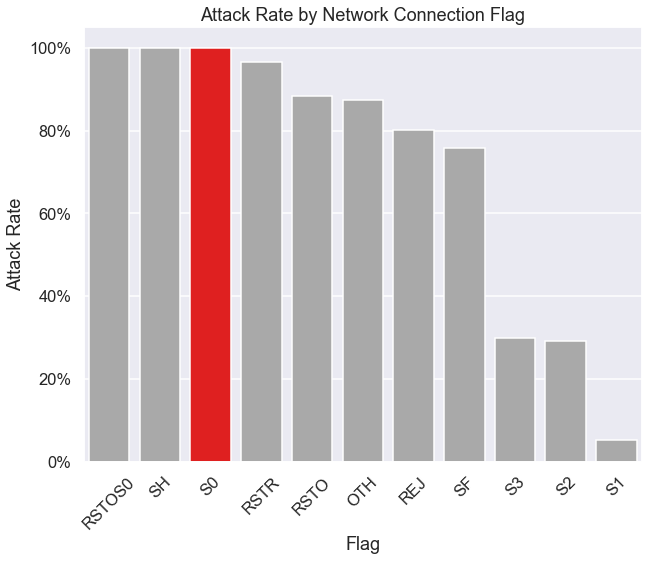

In [37]:
# set plot size
plt.figure(figsize=(10,8))

# set style and context
sns.set_style('darkgrid') 
sns.set_context('talk') 

# create color palette
my_pal = {flag: "r" if flag == 'S0' 
                       else "darkgrey" for flag in total_attacks_per_flag.flag.unique()} 

# initialize barplot in seaborn
ax = sns.barplot(x='flag', y='percent_attack', data=total_attacks_per_flag, palette=my_pal)

# create labels to feed x axis
labels = total_attacks_per_flag['flag'].unique()
ax.set_xticklabels(labels=labels, rotation=45)

# set title and labels
plt.title("Attack Rate by Network Connection Flag")
plt.xlabel("Flag")
plt.ylabel("Attack Rate")

# format y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

We may infer from the data above that S0 flags are associated with network attacks 99.9% of the time. Furthermore, this flag type makes up 87,007 out of a total of 494,020 total connections.

### Continuous Variables 

Now we will begin to investigate the distributions of our continuous variables and their relationship to our target variable. 

In [38]:
# our list of 
cont_features_list= cont_features.columns
cont_features_list

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised',
       'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations',
       'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds',
       'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [39]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,target,attack_type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal,0,NA
1,0,tcp,http,SF,239,486,0,0,0,0,...,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal,0,NA
2,0,tcp,http,SF,235,1337,0,0,0,0,...,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal,0,NA
3,0,tcp,http,SF,219,1337,0,0,0,0,...,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal,0,NA
4,0,tcp,http,SF,217,2032,0,0,0,0,...,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal,0,NA


To start we're going to create two temporary dataframes, one with only attacks and the other with only normal connections. 

In [40]:
# create attack df
attack_df = df[df['target'] == 1]
# create benign df
benign_df = df[df['target'] == 0]

C:\Users\bjane\Miniconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


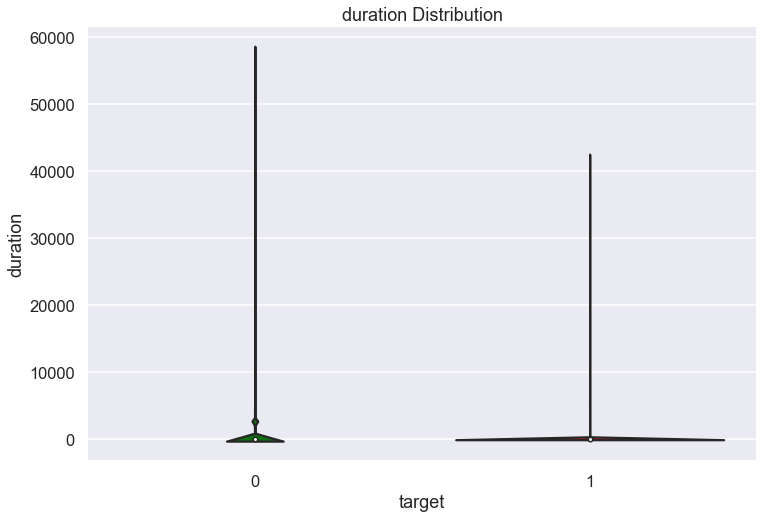

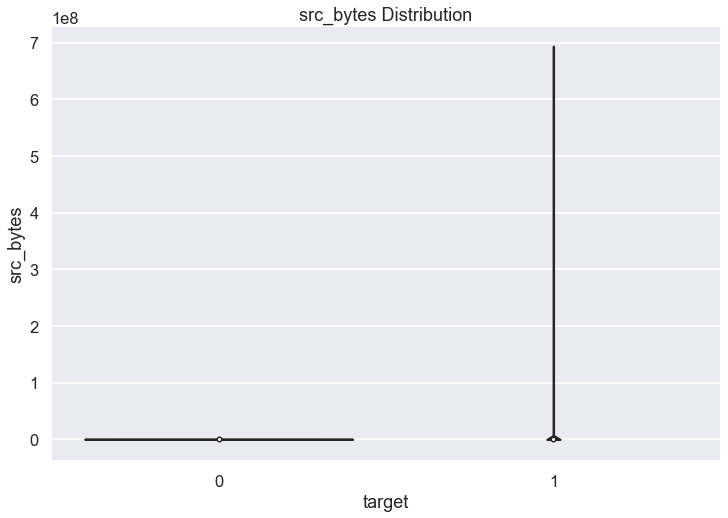

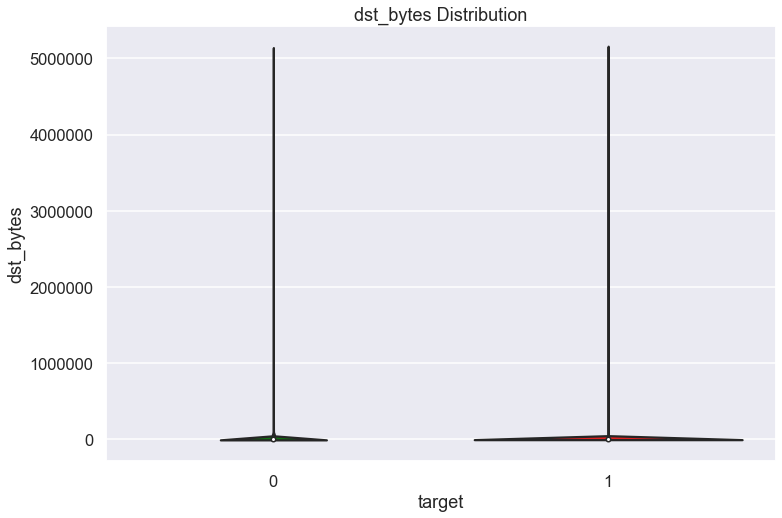

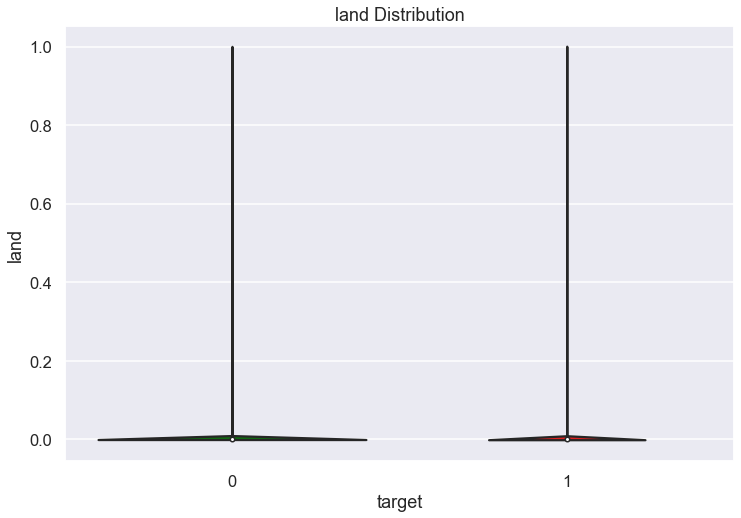

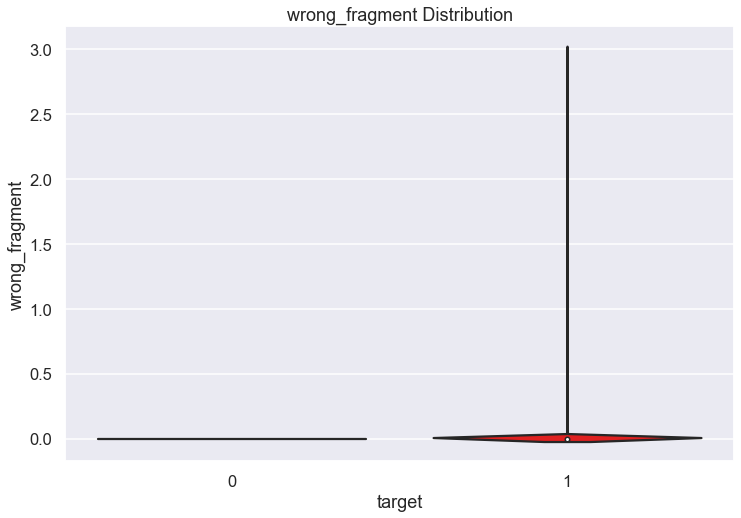

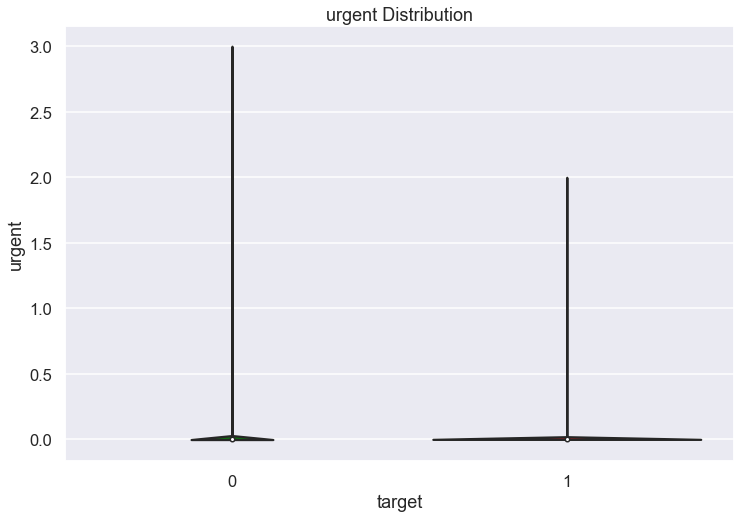

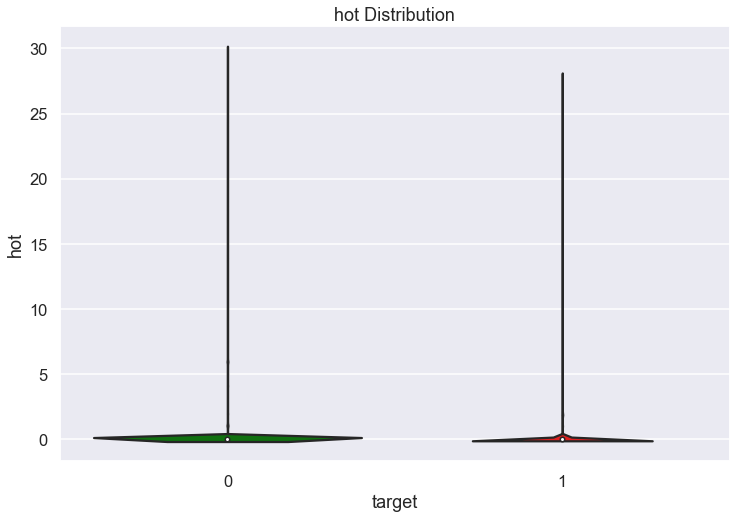

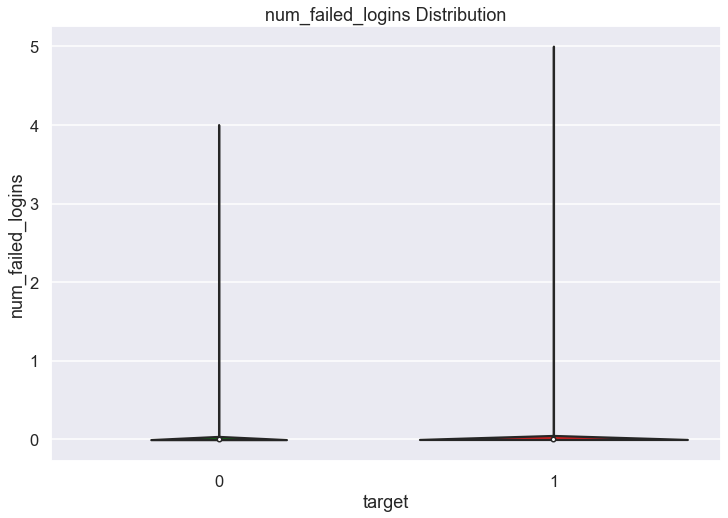

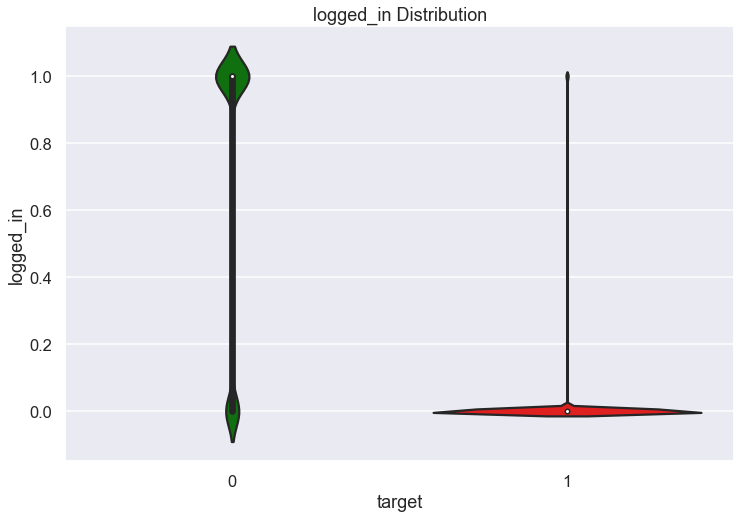

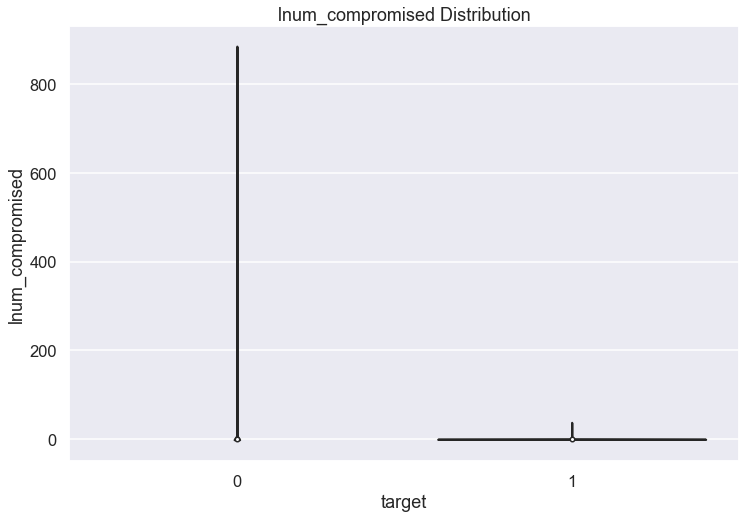

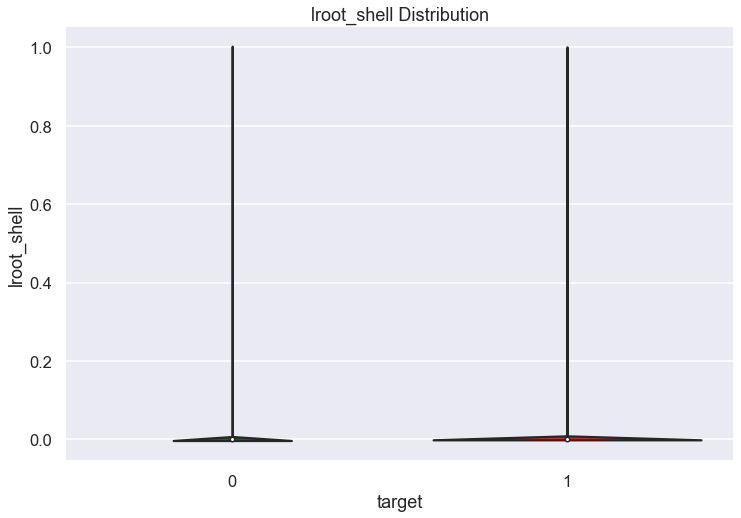

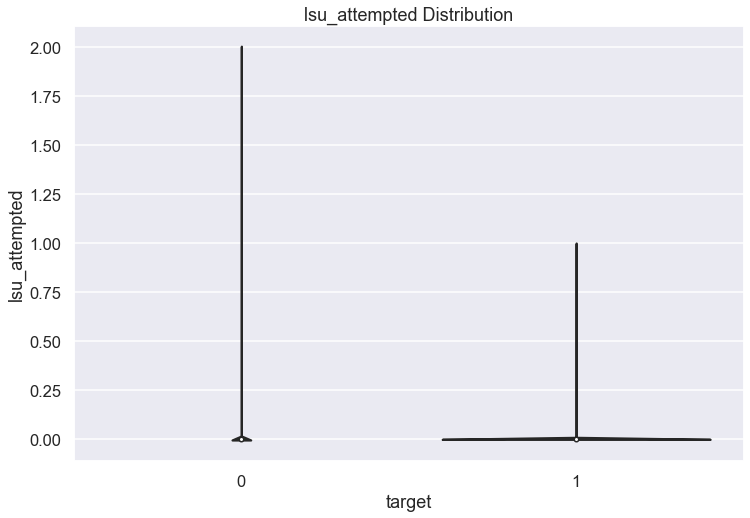

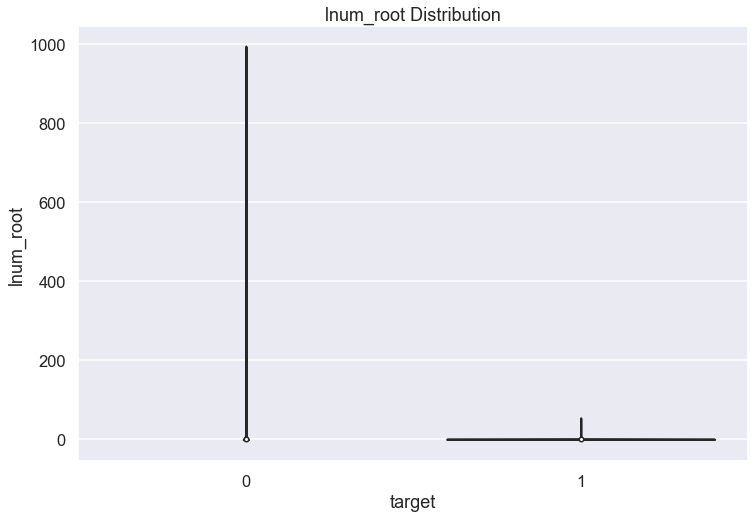

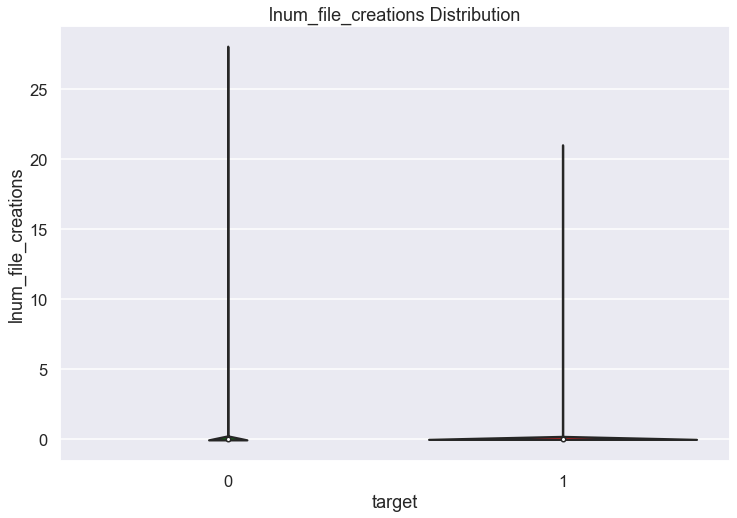

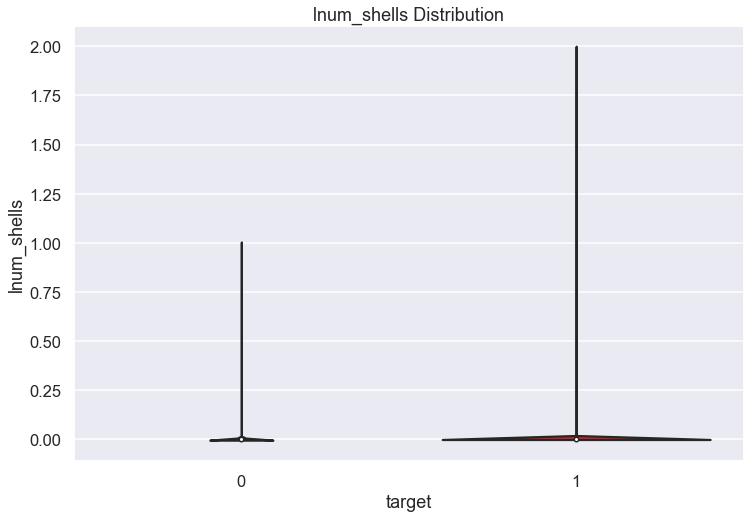

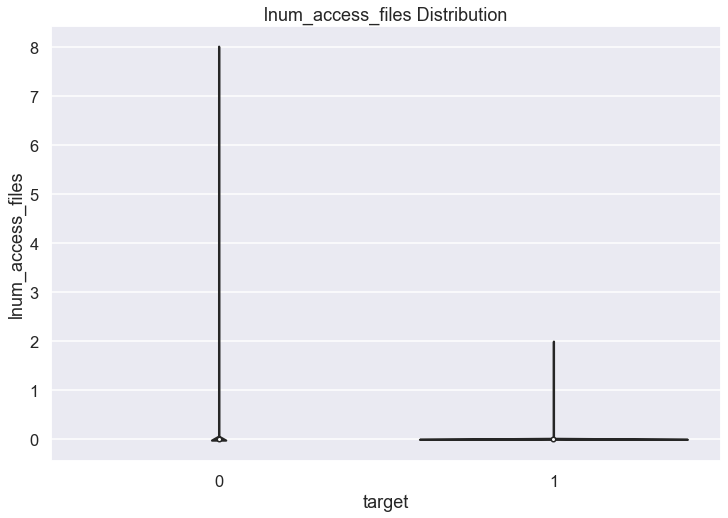

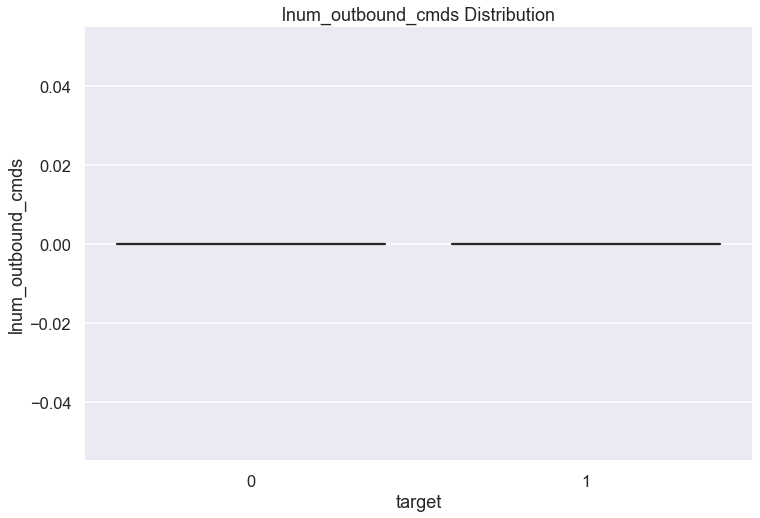

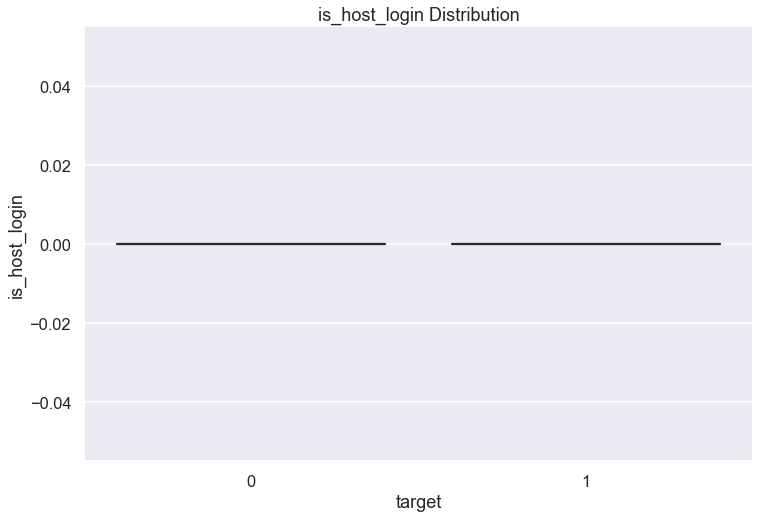

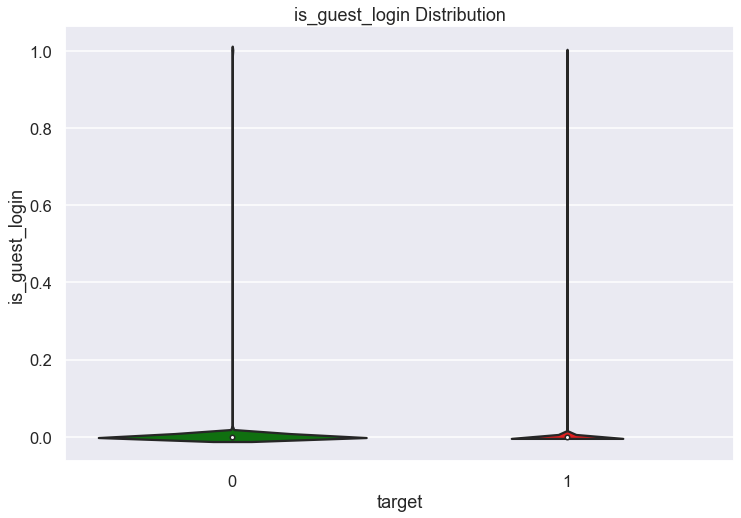

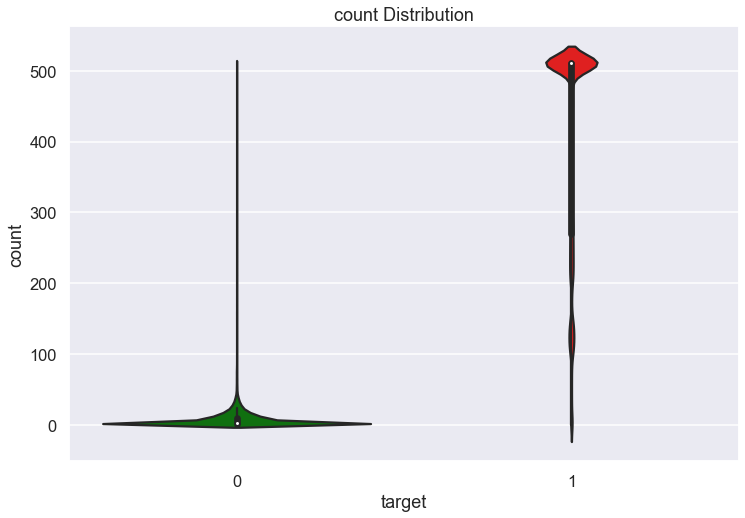

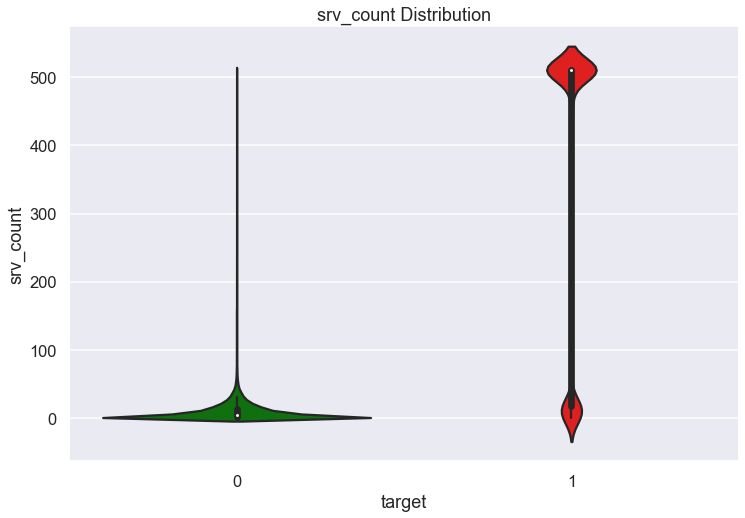

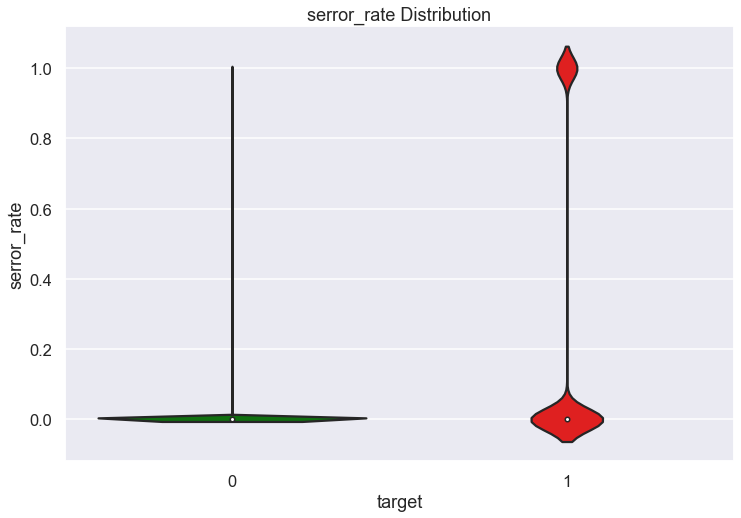

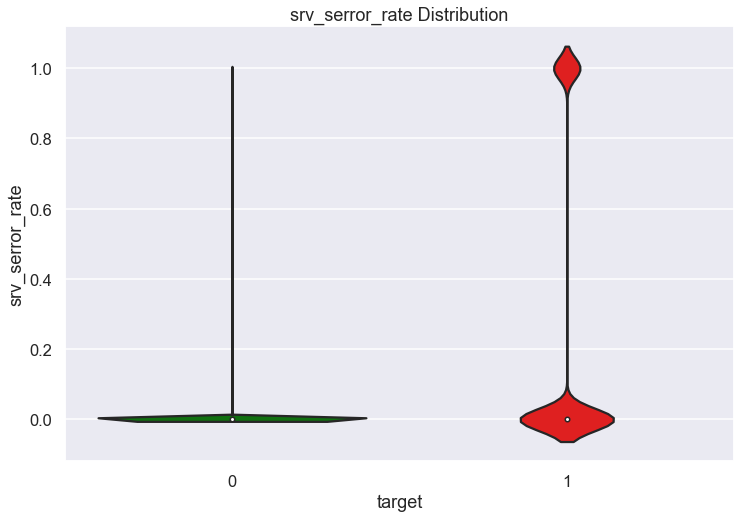

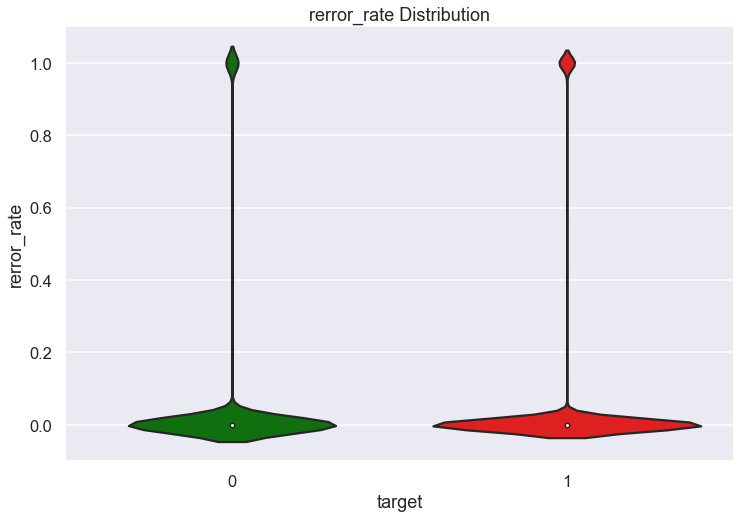

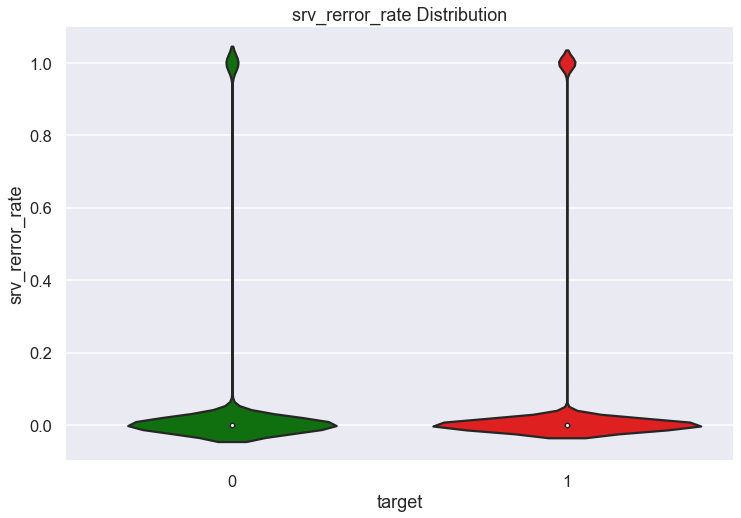

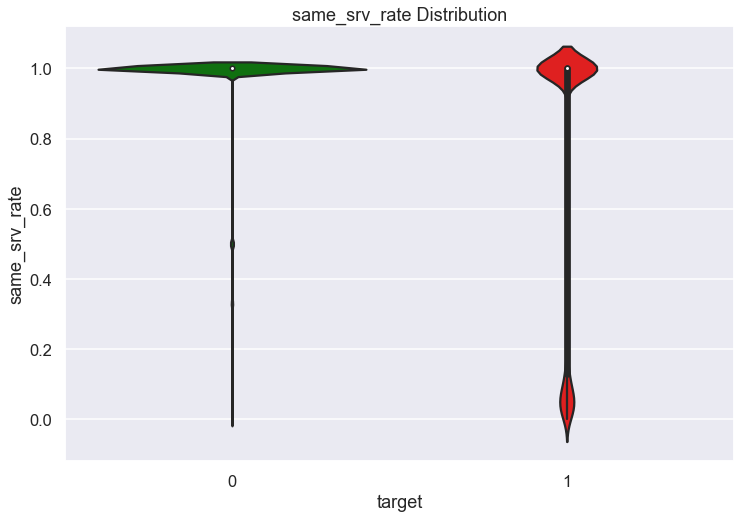

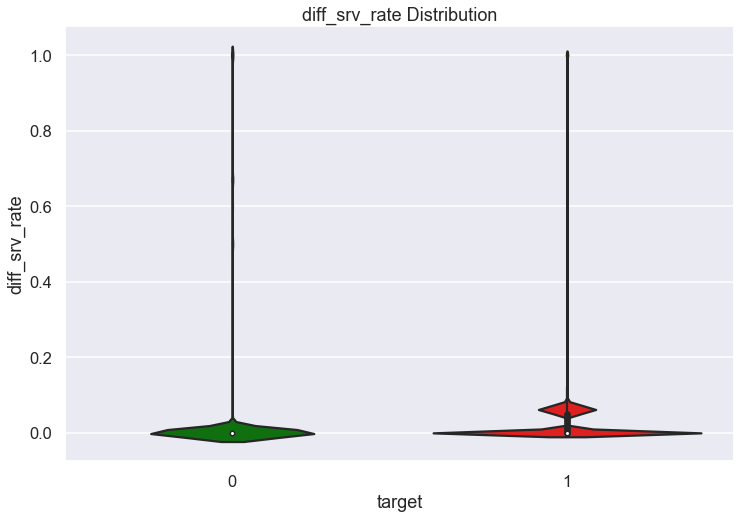

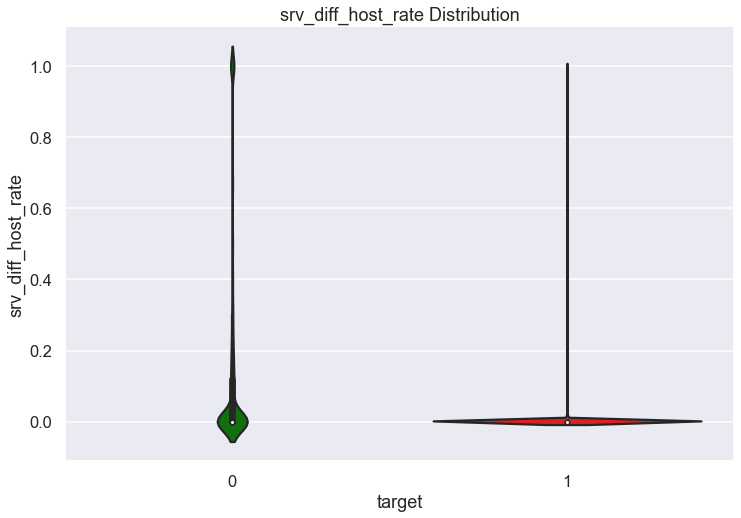

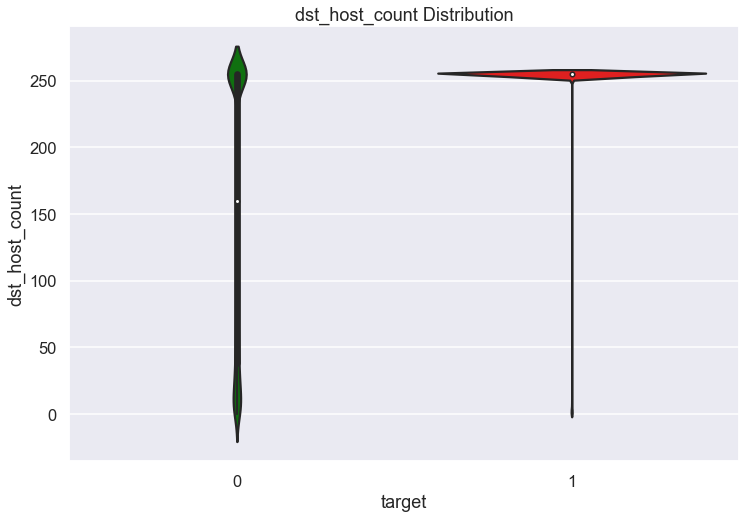

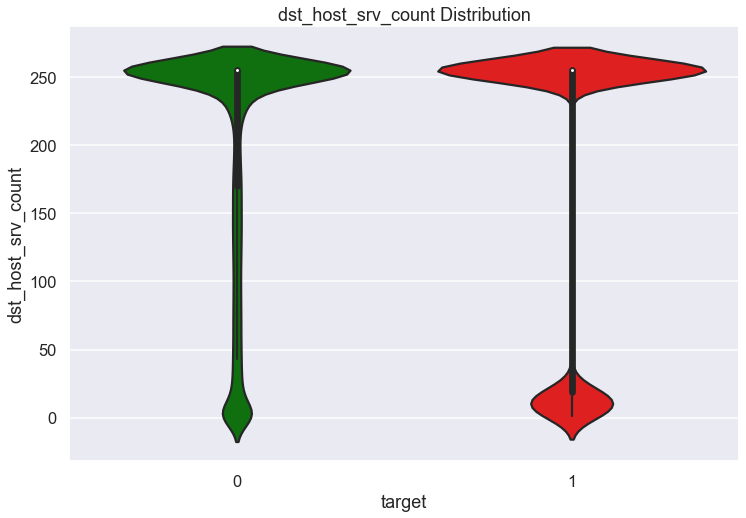

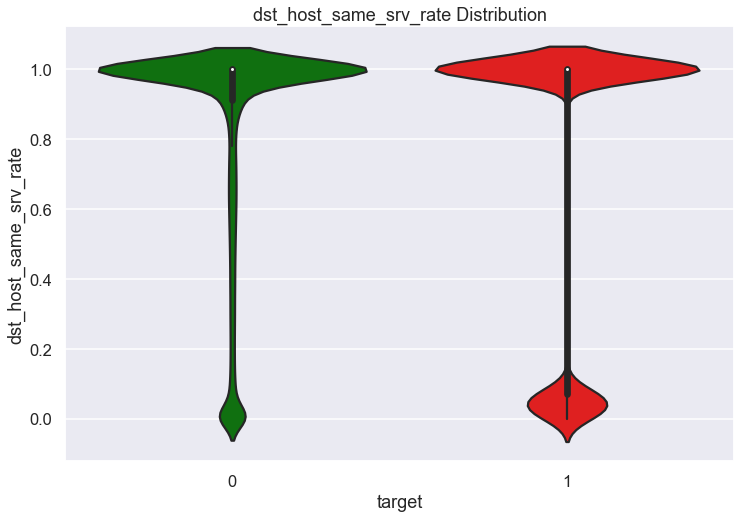

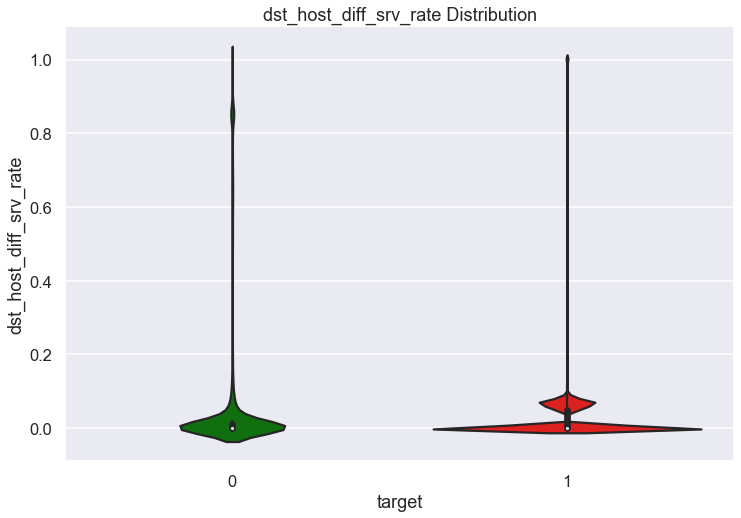

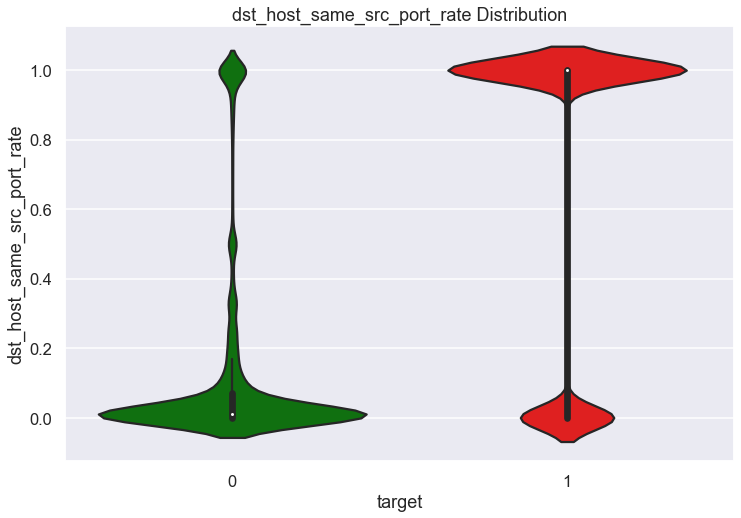

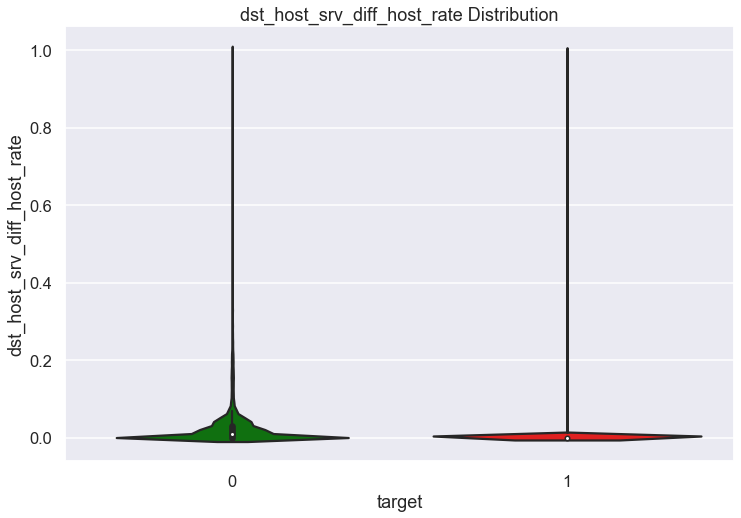

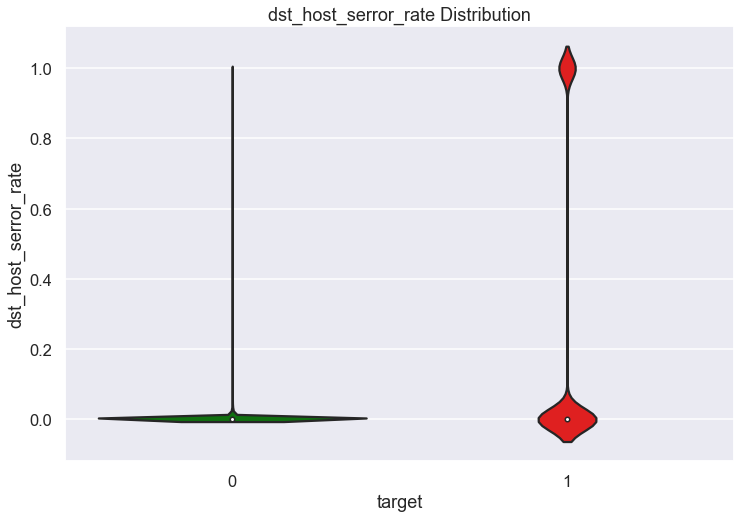

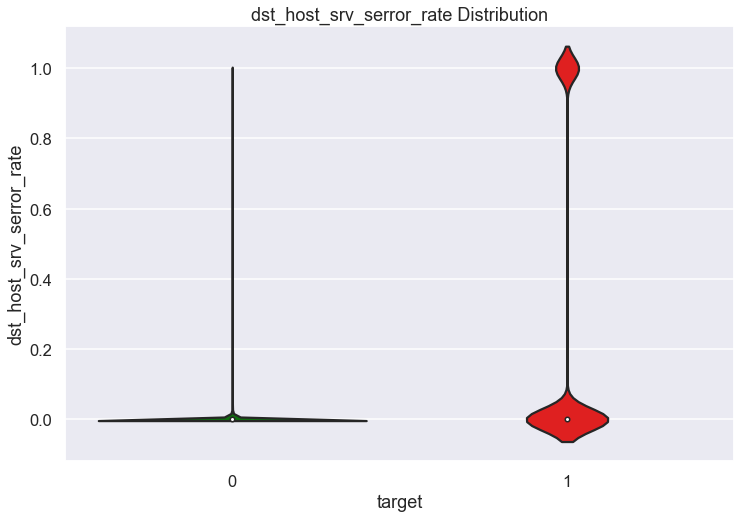

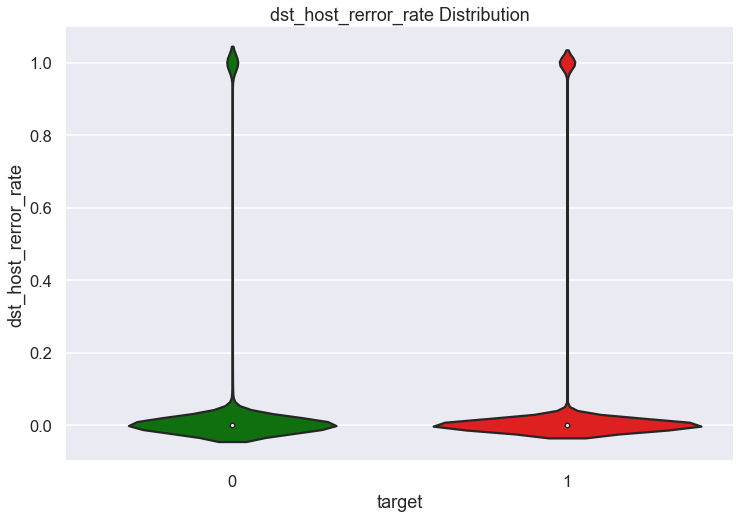

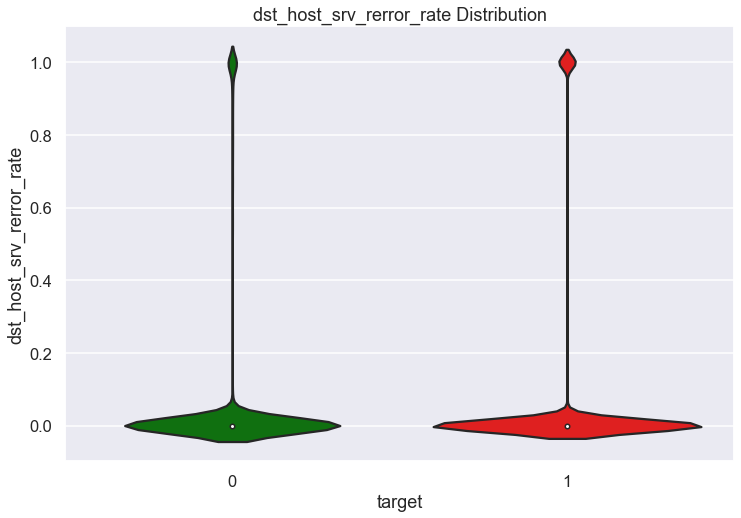

In [41]:
# now let's plot each continuous feature as a distribution
for variable in cont_features_list:
    ax, figure = plt.subplots(1,1,figsize=(12,8))
    p1=sns.violinplot(x="target", y=variable, data=df, palette = ['g', 'r'])
    plt.title("{} Distribution".format(variable))

## Prepare Data for Modeling

Finally, we will create our modeling dataframes. 

In [333]:
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,lnum_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,attack_type,target
0,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.,NA,0
1,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal.,NA,0
2,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack.,R2L,1
3,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.,R2L,1
4,0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack.,R2L,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311023,0,udp,private,SF,105,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.,NA,0
311024,0,udp,private,SF,105,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.,NA,0
311025,0,udp,private,SF,105,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.,NA,0
311026,0,udp,private,SF,105,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal.,NA,0


In [331]:
target = df['target']
features = df.drop(['target', 'label', 'attack_type'], axis=1)

KeyError: 'target'

In [236]:
df['target'] = df['label'].apply(lambda x: 0 if x=='normal' else 1)
df = df.drop('label', axis=1)
df = pd.get_dummies(df, drop_first=True)
df.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=116)

### One Hot Encoding

Now we will one hot encode our categorical variables making sure to drop the first column to prevent the dummy variable trap. 

Furthermore, we need to make sure our training and testing data are one hot encoded in the same way so we have the same number of columns in the correct order. We did this in another notebook in the repository and save the dataframes as pickle objects. We will import the one for training here. 

In [340]:
train_df = pd.read_pickle('train_df_w_congruent_columns.pkl')

In [341]:
train_df.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=116)

In [342]:
train_df.shape

(494020, 116)

### Train and Validation Sets

In [343]:
X_train, X_val, y_train, y_val = train_test_split(train_df, target, test_size=0.25, random_state=42)

In [344]:
X_train.shape

(370515, 116)

### Scaling and Normalization

Scaling and /or normalization will be done depending on the needs of each classification algorithm. 

# Initial Classification Model: Logistic Regression

## Baseline Logistic Regression

First we'll start with a simple logistic regression model to use as a baseline. We'll use L1 (Lasso) regularization so that we may cancel out unimportant features and will tweak our regularization parameter later using grid search. The 'saga' solver will be used as that is recommended for large datasets. 

Note 1: As an experiment we tried the 'liblearner' solver and it had much higher accuracy. It appears the 'saga' solver was having trouble converging - even moreso than 'sage'. We could sit here and adjust max_iters to try and find the true ideal solver for this problem, however, time is of essense and we must move on to other classifiers. 

Note 2: There was no significant difference between using StandardScaler() or RobustScaler() on this algorithm. RobustScaler() is designed to be more robust to outlier data. 

In [24]:
# initialize logistic regression instance using L1 regularization (feature selection) and 'liblearner' solver for L1 reg
logreg_clf = LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=42) 

Before fitting the data let's scale all features using standard scaler. 

In [493]:
# initialize standardscaler(); make sure to fit_transform train and val sets separately to prevent data leakage
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [494]:
# fit classifier to training data
logreg_clf.fit(X_train_scaled, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Baseline Logistic Regression Tree Classifier Training Data Scores

Recall Score: 99.167%
Precision Score: 99.752%
Accuracy Score: 99.133%
F1 Score: 0.99458
ROC AUC Score: 0.9908

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


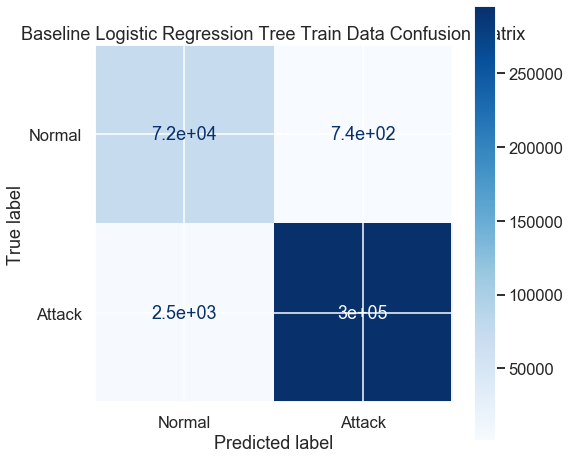


Train Data ROC Curve
---------------------------------------------------------------------------------------


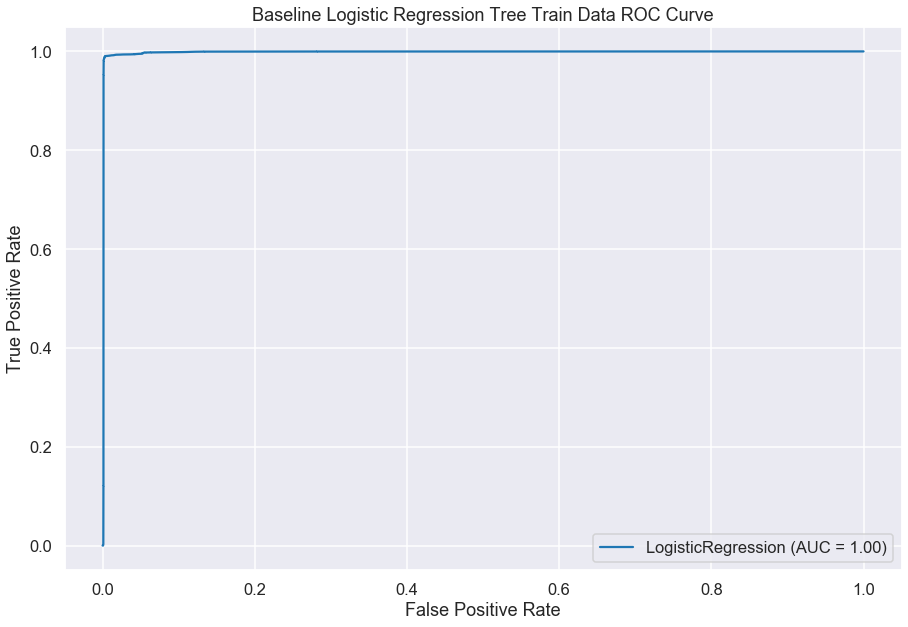


TESTING SET METRICS
--------------------------------------------------------------------------------------
Baseline Logistic Regression Tree Classifier Testing Data Scores

Recall Score: 99.145%
Precision Score: 99.756%
Accuracy Score: 99.118%
F1 Score: 0.9945
ROC AUC Score: 0.99076

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


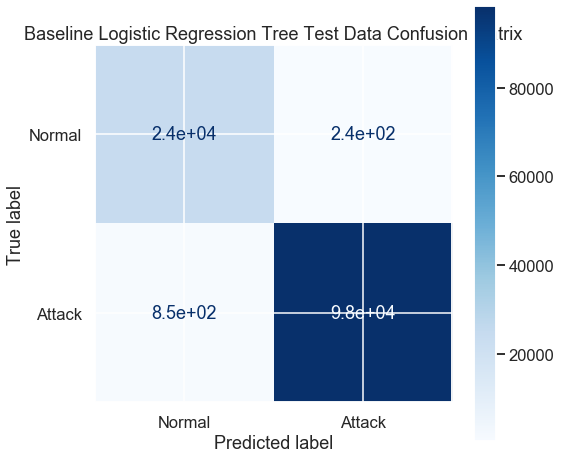


Test Data ROC Curve
---------------------------------------------------------------------------------------


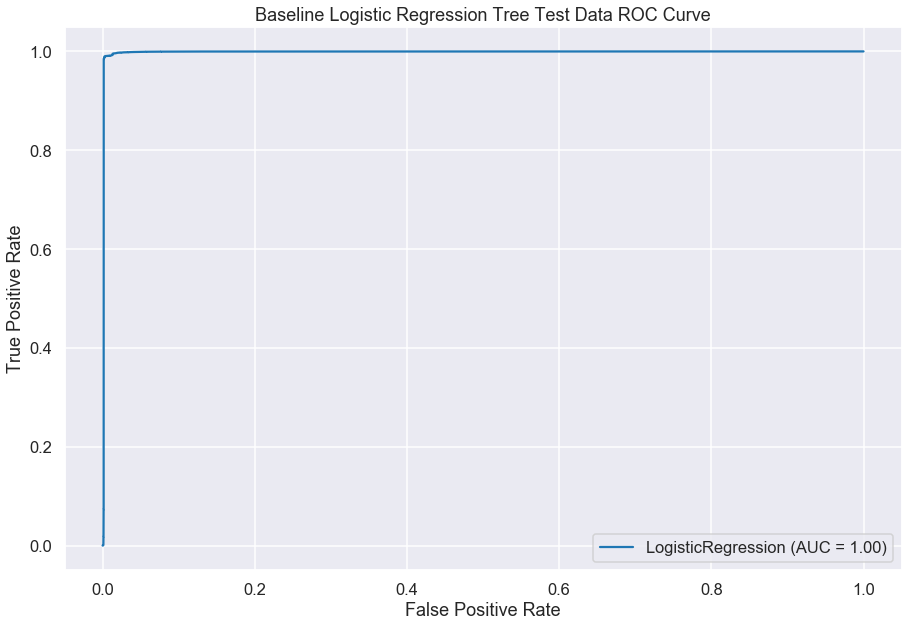

In [495]:
# evaluate model
binary_classification_evaluation(logreg_clf, X_train_scaled, X_val_scaled, y_train, y_val, 
                                 name_of_estimator="Baseline Logistic Regression Tree",
                                 cm_labels=['Normal', 'Attack'], is_ANN=False)

Let's see how many coefficients our regularized logistic regression algorithm cancelled out. 

In [32]:
# finally let's take a look at the coefficients of our decision function
sum(logreg_clf.coef_==0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

## Tuned Logistic Regression: Grid Search and Cross Validation Pipeline

Now that we have a baseline model to compare to we will proceed to fine tune our logistic regression model. We will tune two hyperparameters - the regularization coefficient C and the fit intercept option. These will be tested using a five-fold cross-validation. A pipeline will be used to prevent data leakage during the scaling process. 

Note that our 'saga' solver is having difficulty converging so we may switch to 'liblinear'. 

In [497]:
# initialize logistic regression pipeline
logreg_pipeline = Pipeline([('logreg', LogisticRegression(solver='liblinear', random_state=42, max_iter=100))])

# define grid parameters
logreg_grid = [{'logreg__C': [1, 100]}]

# initialize grid object
logreg_gridsearch = GridSearchCV(estimator=logreg_pipeline,
                                 param_grid=logreg_grid, 
                                 scoring='roc_auc',
                                 cv=4)

# fit to train data
logreg_gridsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=42,
                                                

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Tuned Logistic Regression Classifier Training Data Scores

Recall Score: 99.904%
Precision Score: 99.935%
Accuracy Score: 99.871%
F1 Score: 0.99919
ROC AUC Score: 0.9982

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


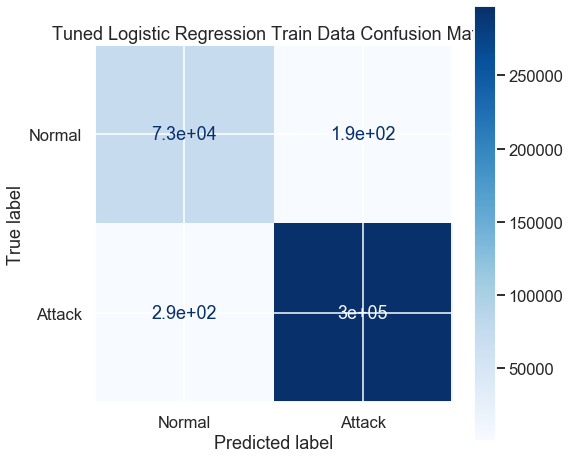


Train Data ROC Curve
---------------------------------------------------------------------------------------


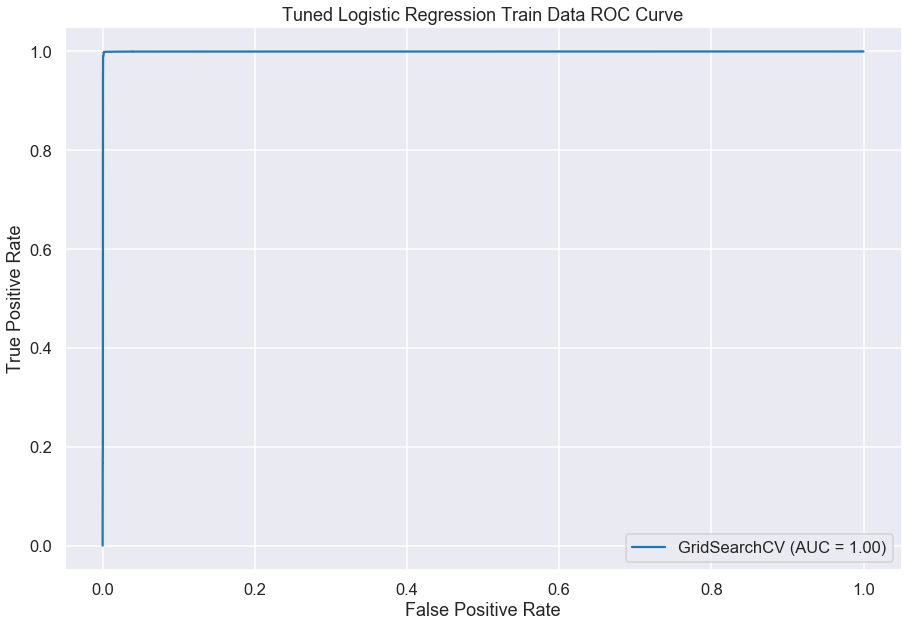


TESTING SET METRICS
--------------------------------------------------------------------------------------
Tuned Logistic Regression Classifier Testing Data Scores

Recall Score: 99.864%
Precision Score: 99.923%
Accuracy Score: 99.829%
F1 Score: 0.99894
ROC AUC Score: 0.99775

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


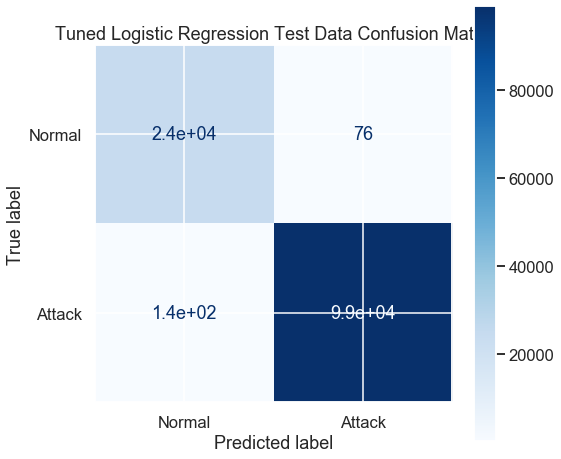


Test Data ROC Curve
---------------------------------------------------------------------------------------


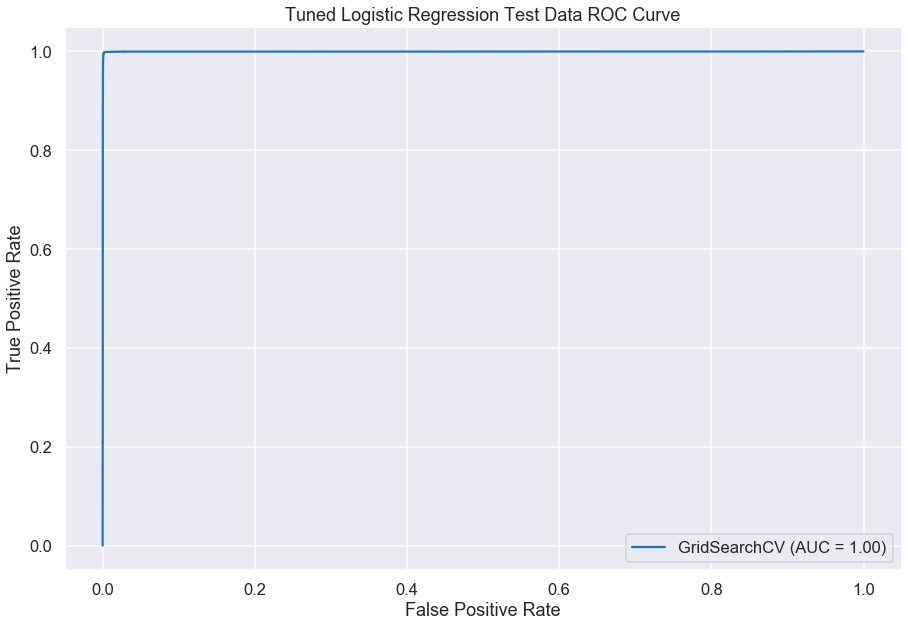

In [499]:
# evaluate grid search model
binary_classification_evaluation(logreg_gridsearch, X_train_scaled, X_val_scaled, y_train, y_val, 
                                 name_of_estimator="Tuned Logistic Regression",
                                 cm_labels=['Normal', 'Attack'], is_ANN=False)

In [500]:
# save gridsearch model
joblib.dump(logreg_gridsearch, 'logreg_gridsearch.pkl') 


['logreg_gridsearch.pkl']

Let's see what our best estimator was. 

In [501]:
logreg_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('logreg',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

## Embedded Feature Selection

Let's see what features our optimized logistic regression classifier zeroed out using Lasso regularization. Out of 115 features, eliminating three isn't very impressive, however, our optimized regularization coefficient is rather high at C=100. 

In [41]:
# create list of 
unimportant_features = X_train.columns[(logreg_gridsearch.best_estimator_[1].coef_ == 0).ravel().tolist()]
unimportant_features

Index(['lnum_outbound_cmds', 'is_host_login', 'service_tftp_u'], dtype='object')

# Decision Tree and Ensemble Methods

## Decision Trees

### Baseline Decision Tree

In [369]:
# initialize decision tree
dt_clf = DecisionTreeClassifier(criterion='entropy')

# fit decision tree
dt_clf.fit(X_train, y_train)

# make predictions
dt_clf_y_hat_train = dt_clf.predict(X_train)
dt_clf_y_hat_val = dt_clf.predict(X_val)

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Baseline Decision Tree Classifier Training Data Scores

Recall Score: 100.0%
Precision Score: 100.0%
Accuracy Score: 100.0%
F1 Score: 1.0
ROC AUC Score: 1.0

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


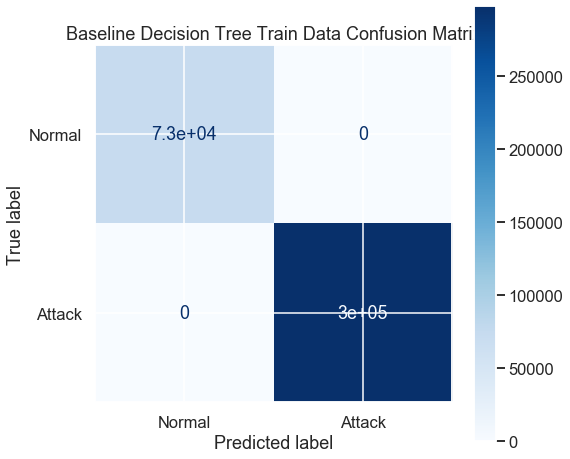


Train Data ROC Curve
---------------------------------------------------------------------------------------


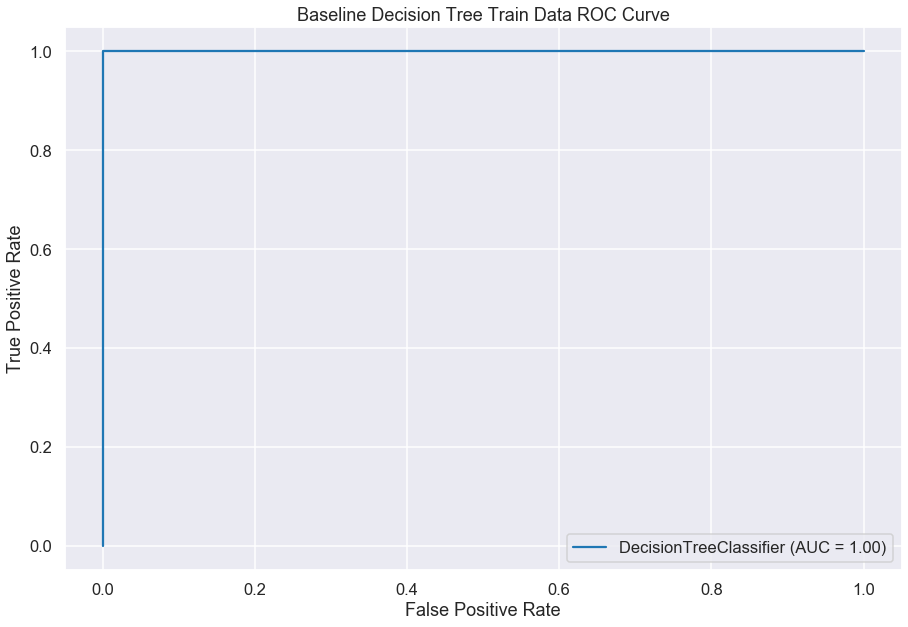


TESTING SET METRICS
--------------------------------------------------------------------------------------
Baseline Decision Tree Classifier Testing Data Scores

Recall Score: 99.982%
Precision Score: 99.981%
Accuracy Score: 99.97%
F1 Score: 0.99981
ROC AUC Score: 0.99952

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


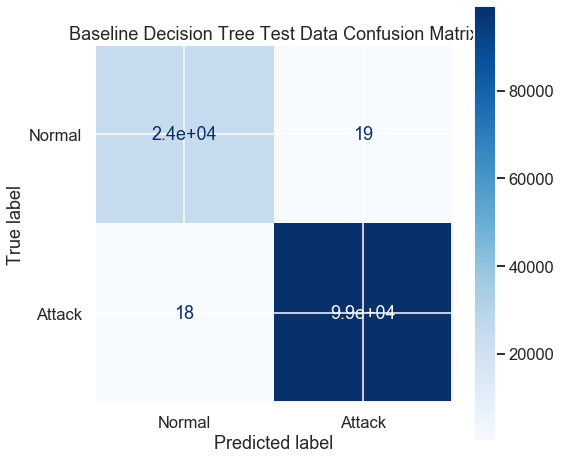


Test Data ROC Curve
---------------------------------------------------------------------------------------


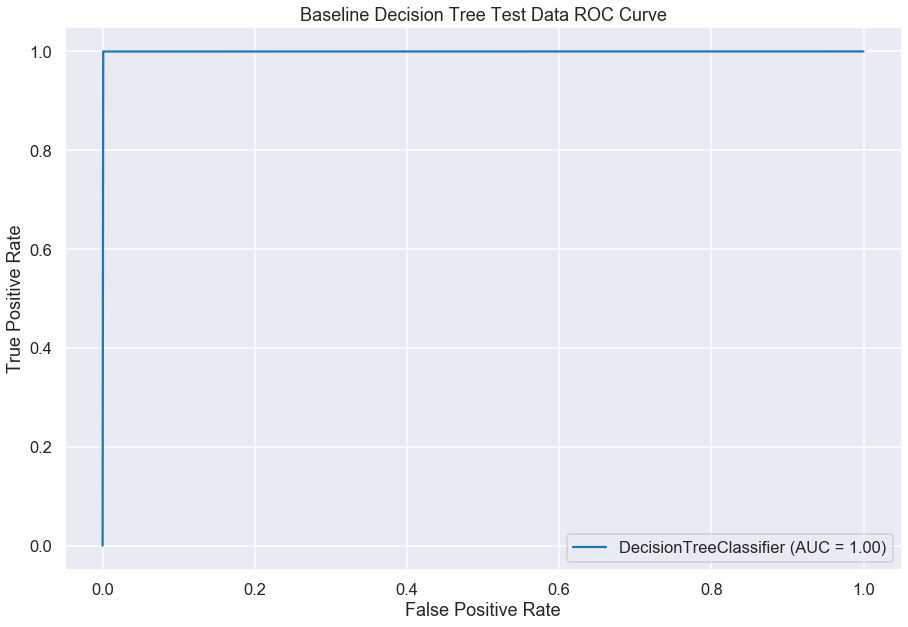

In [485]:
# evaluate classifier
binary_classification_evaluation(dt_clf, X_train, X_val, y_train, y_val, 
                                 name_of_estimator="Baseline Decision Tree",
                                 cm_labels=['Normal', 'Attack'], is_ANN=False)

Now we will evaluate the most important features of our decision tree. 

In [373]:
dt_clf.feature_importances_

array([5.38946040e-04, 4.17968235e-02, 3.91706470e-02, 0.00000000e+00,
       3.03556691e-05, 0.00000000e+00, 3.41354627e-02, 1.43268953e-05,
       1.25111737e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.15031291e-05, 6.39125444e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.77972040e-05, 8.45236134e-01,
       0.00000000e+00, 1.03858396e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.36082315e-05, 1.99316603e-05, 1.87209187e-05,
       6.27710012e-03, 3.25794470e-04, 4.19849097e-04, 8.04968555e-04,
       1.15276679e-03, 9.12356736e-04, 6.87544449e-04, 1.74446278e-03,
       6.53370517e-05, 2.28224396e-05, 2.60650751e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.66510211e-05, 0.00000000e+00,
       0.00000000e+00, 1.59493029e-03, 0.00000000e+00, 0.00000000e+00,
      

Our decision tree gave zero information gain to 78 features out of 115. Only 37 provided any information. 

In [374]:
sum(dt_clf.feature_importances_== 0)

76

In [375]:
dt_clf.get_depth()

14

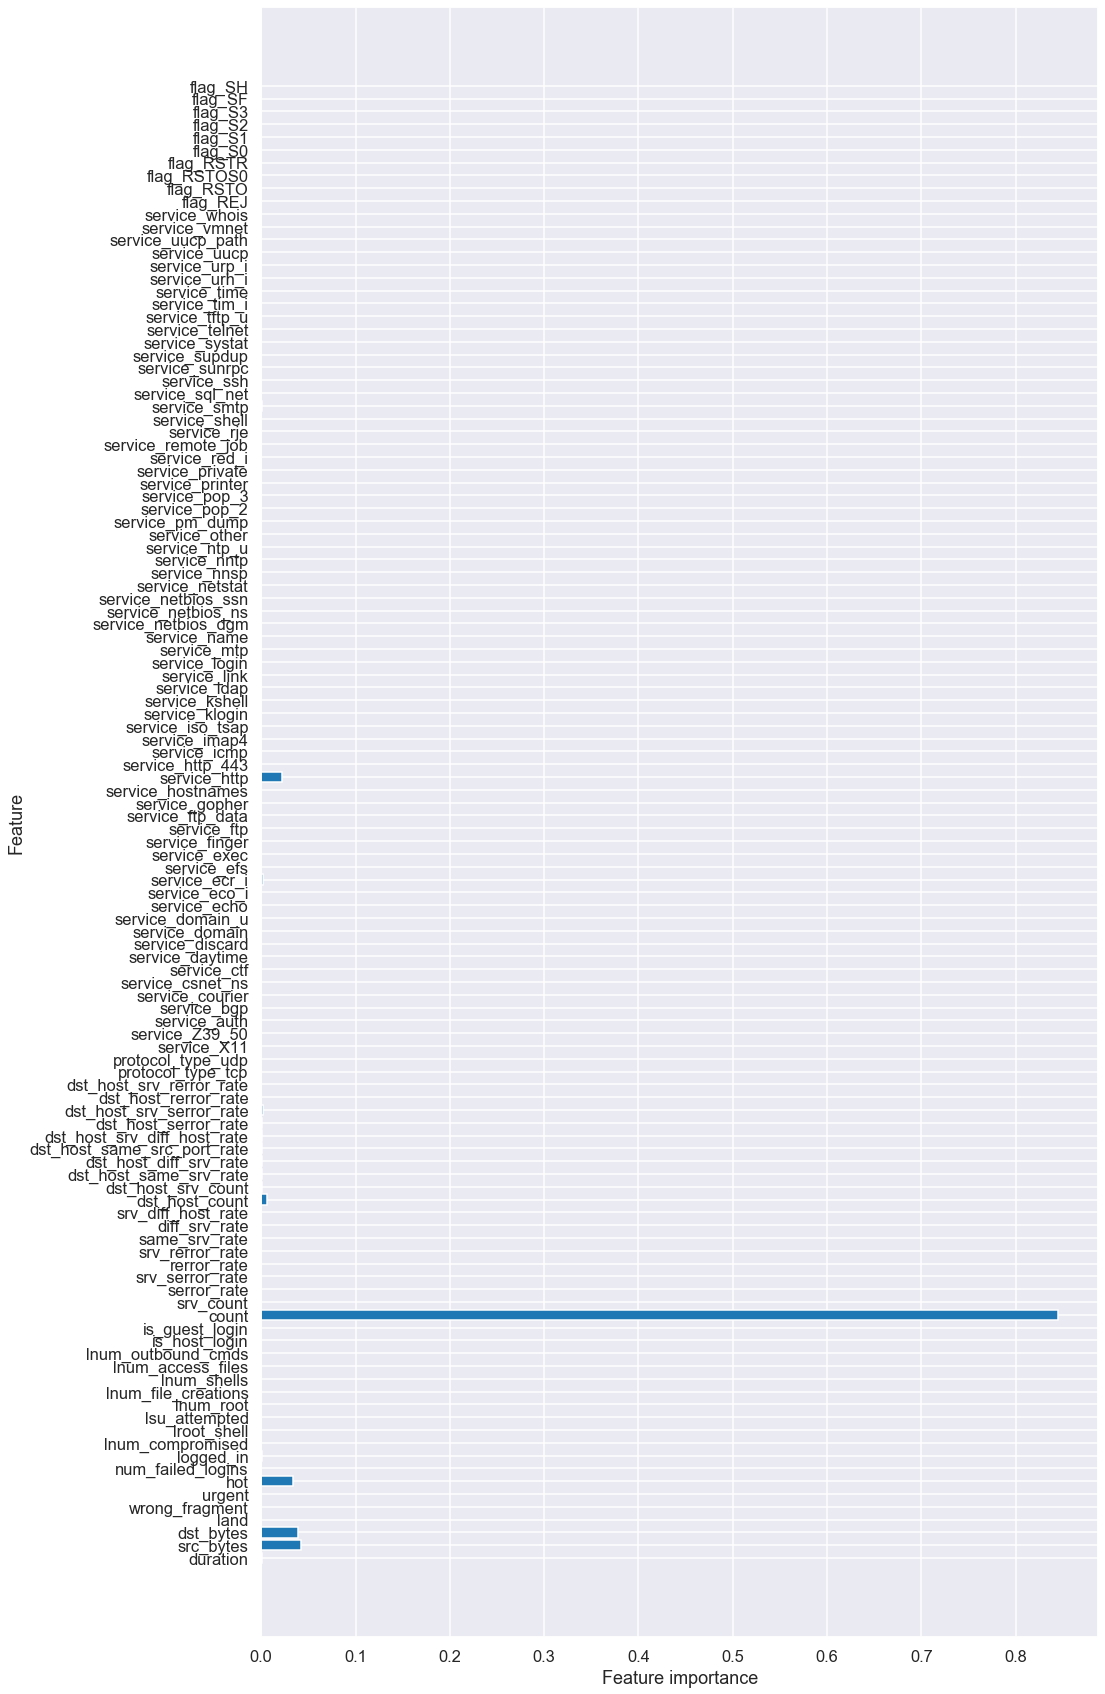

In [376]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(15,30))
    plt.barh(range(n_features), dt_clf.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dt_clf)

Notable here, the 'count' feature contributes the most amount of information gain by a significant margin. The 'count' feature is described as the number of connections to the same host of the current connection in the past two seconds. This is likely due to the fact that the majority of our attacks are DoS attacks where a host is flooded with requests. 

### Tuned Decision Tree

Wow, it is impossible to beat 100% accuracy, precision, and recall on the train set, however, may be could marginally improve the testing score. 

In [378]:
# initialize decision tree pipeline
dt_pipeline = Pipeline([('dt', DecisionTreeClassifier(criterion='entropy', random_state=42))])

# define grid parameters
dt_grid = [{'dt__max_depth': [3, 5, None]},
           # already tested min_samples_split and min_samples_leaf
           {'dt__min_samples_split': [2]},
           {'dt__min_samples_leaf': [1]}]

# initialize grid object
dt_gridsearch = GridSearchCV(estimator=dt_pipeline,
                             param_grid=dt_grid,
                             scoring='roc_auc',
                             cv=4)

# fit to train data
dt_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('dt',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='entropy',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                                       

In [379]:
dt_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('dt',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='entropy', max_depth=5,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=42,
                                        splitter='best'))],
         verbose=False)

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Tuned Decision Tree Classifier Training Data Scores

Recall Score: 99.905%
Precision Score: 99.895%
Accuracy Score: 99.839%
F1 Score: 0.999
ROC AUC Score: 0.99738

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


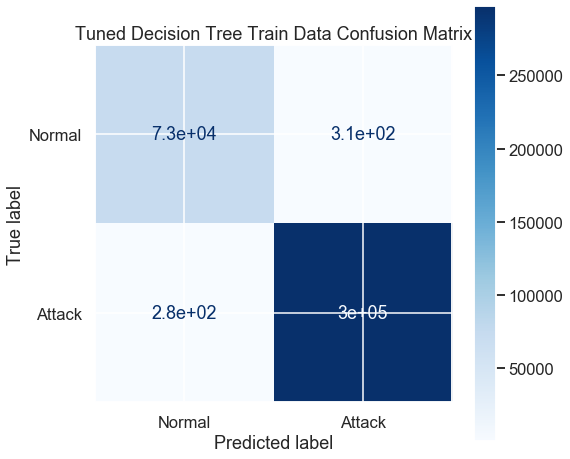


Train Data ROC Curve
---------------------------------------------------------------------------------------


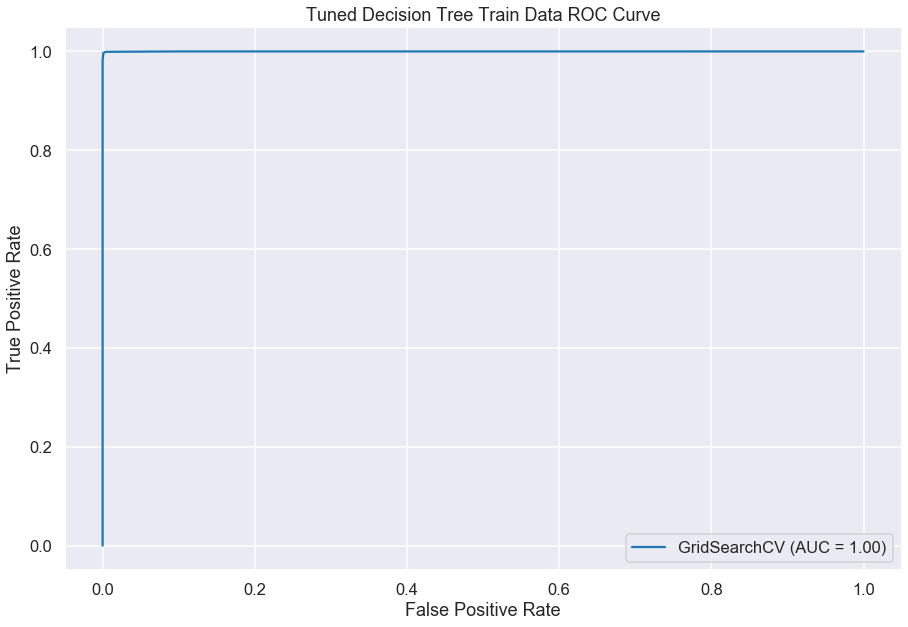


TESTING SET METRICS
--------------------------------------------------------------------------------------
Tuned Decision Tree Classifier Testing Data Scores

Recall Score: 99.908%
Precision Score: 99.874%
Accuracy Score: 99.825%
F1 Score: 0.99891
ROC AUC Score: 0.99697

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


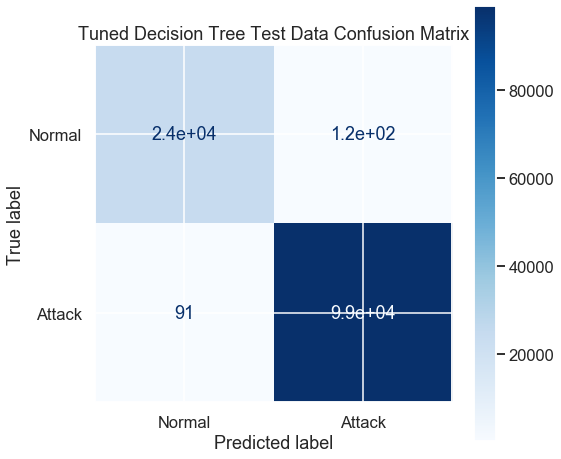


Test Data ROC Curve
---------------------------------------------------------------------------------------


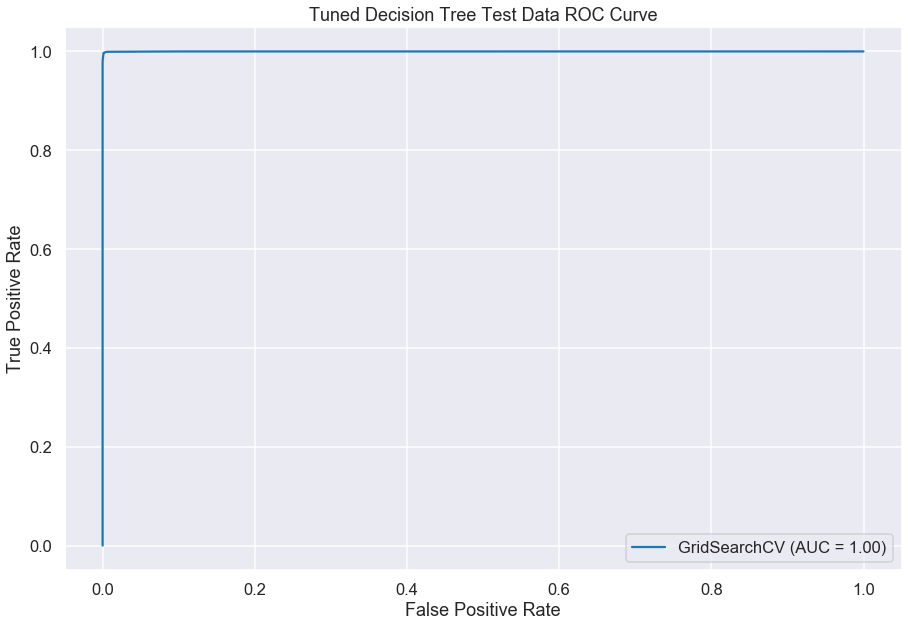

In [380]:
# evaluate classifier
binary_classification_evaluation(dt_gridsearch, X_train, X_val, y_train, y_val, 
                                 name_of_estimator="Tuned Decision Tree",
                                 cm_labels=['Normal', 'Attack'], is_ANN=False)

Tuning hyperparameters had no effect on the performance of this decision tree. 

In [381]:
# save gridsearch model
joblib.dump(dt_gridsearch, 'dt_gridsearch.pkl') 

['dt_gridsearch.pkl']

## Random Forest

Let's now try using a random forest algorithm. Random forests work by creating an ensemble of trees, each of which is trained and tested on a randomly selected subset of data and is split using randomly selected features. The strength of this method is strength in numbers and should help create a more generalized algorithm that performs better on new data by avoiding overfitting during training. 

### Baseline Random Forest

In [382]:
# initialize random forest classifier
forest_clf = RandomForestClassifier(n_estimators=100)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Baseline Random Forest Classifier Training Data Scores

Recall Score: 100.0%
Precision Score: 100.0%
Accuracy Score: 100.0%
F1 Score: 1.0
ROC AUC Score: 1.0

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


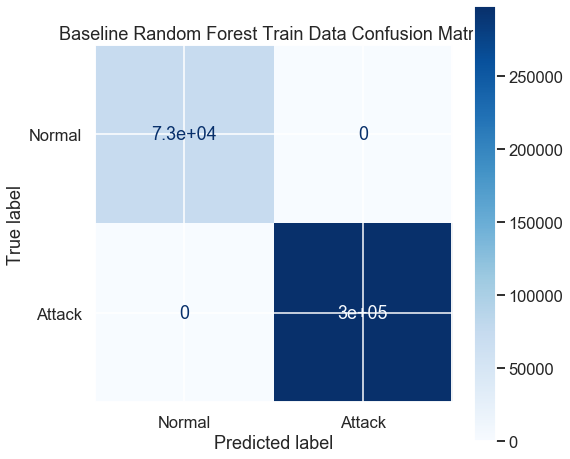


Train Data ROC Curve
---------------------------------------------------------------------------------------


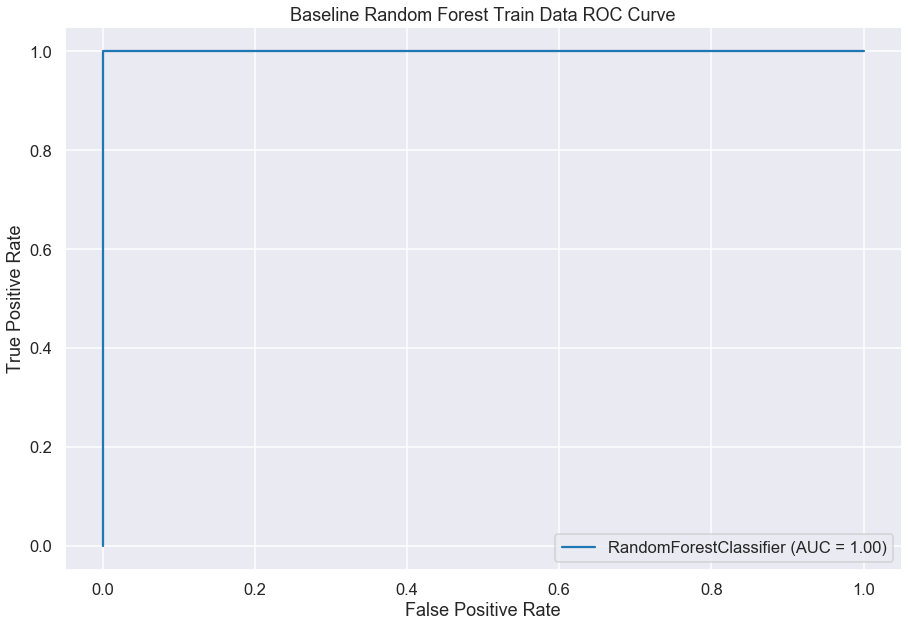


TESTING SET METRICS
--------------------------------------------------------------------------------------
Baseline Random Forest Classifier Testing Data Scores

Recall Score: 99.974%
Precision Score: 99.994%
Accuracy Score: 99.974%
F1 Score: 0.99984
ROC AUC Score: 0.99975

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


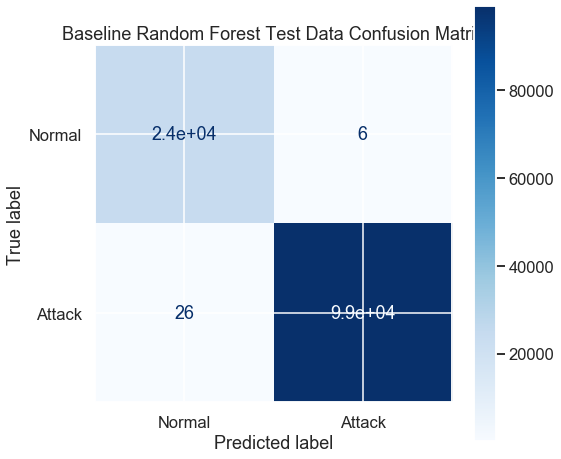


Test Data ROC Curve
---------------------------------------------------------------------------------------


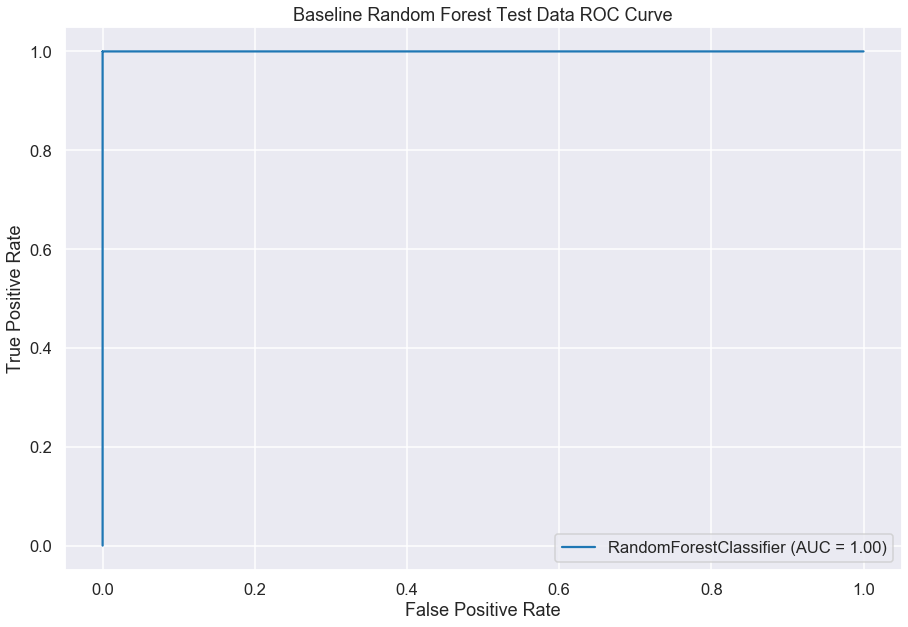

In [383]:
# evaluate classifier
binary_classification_evaluation(forest_clf, X_train, X_val, y_train, y_val, 
                                 name_of_estimator="Baseline Random Forest",
                                 cm_labels=['Normal', 'Attack'], is_ANN=False)

Compared to our decision tree classifier, this mmodel performed better across all metrics. Let's tune some parameters and see if we can improve at all. This is by far the most impressive algorithm we've used so far. 

### Tuned Random Forest

For our tuned 'max_features' we will test Auto and the square root of the total number of features. 

In [385]:
# initialize forest pipeline
forest_pipeline = Pipeline([('forest', RandomForestClassifier(random_state=42))])

# define grid parameters
forest_grid = [{'forest__n_estimators': [500, 1000]},
               # already tested max_depth, min_samples_split, min_samples_leaf
               {'forest__max_depth': [None]},
               {'forest__min_samples_split': [2]},
               {'forest__min_samples_leaf': [1]}]

# initialize grid object
forest_gridsearch = GridSearchCV(estimator=forest_pipeline,
                                 param_grid=forest_grid,
                                 scoring='roc_auc',
                                 cv=4)

# fit to train data
forest_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('forest',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                           

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Tuned Random Forest Classifier Training Data Scores

Recall Score: 100.0%
Precision Score: 100.0%
Accuracy Score: 100.0%
F1 Score: 1.0
ROC AUC Score: 1.0

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


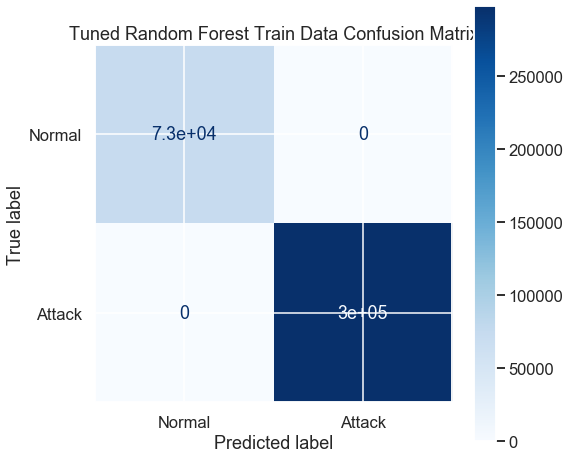


Train Data ROC Curve
---------------------------------------------------------------------------------------


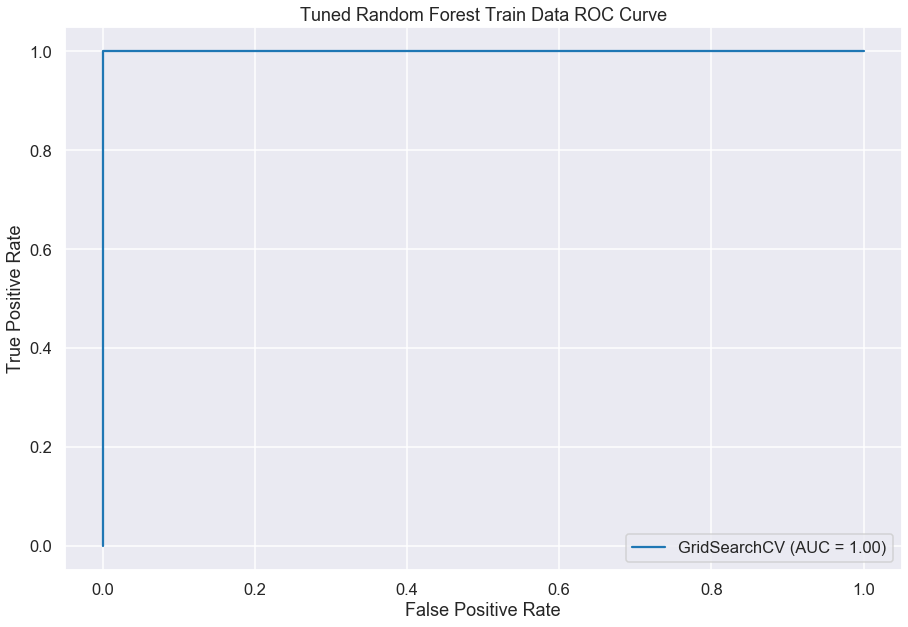


TESTING SET METRICS
--------------------------------------------------------------------------------------
Tuned Random Forest Classifier Testing Data Scores

Recall Score: 99.974%
Precision Score: 99.993%
Accuracy Score: 99.973%
F1 Score: 0.99983
ROC AUC Score: 0.99972

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


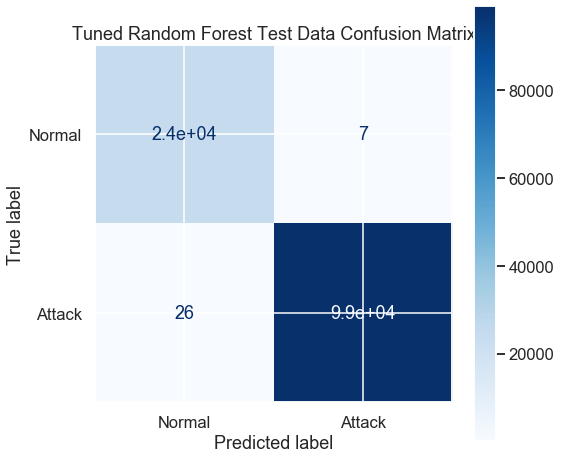


Test Data ROC Curve
---------------------------------------------------------------------------------------


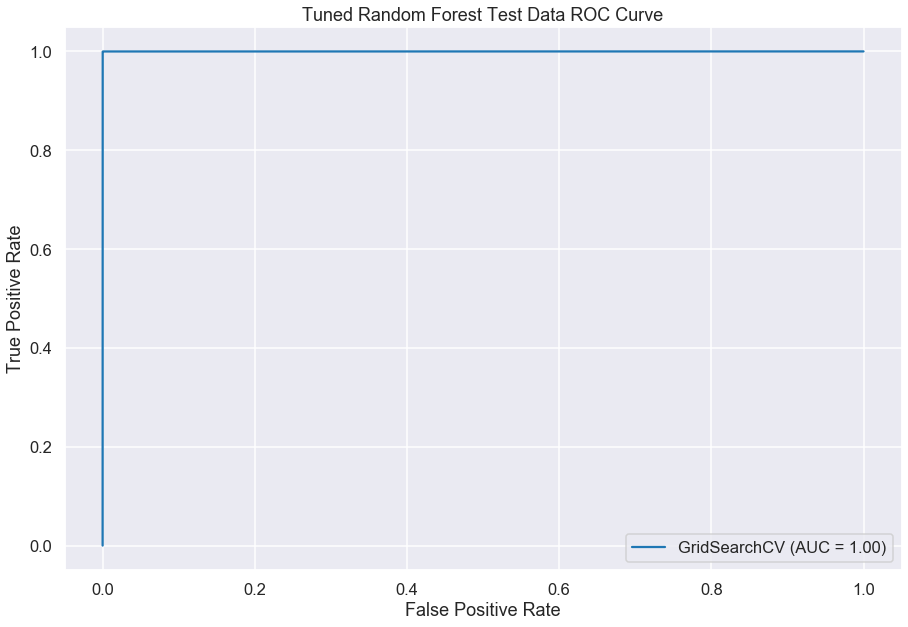

In [386]:
binary_classification_evaluation(forest_gridsearch, X_train, X_val, y_train, y_val, 
                                 name_of_estimator="Tuned Random Forest",
                                 cm_labels=['Normal', 'Attack'], is_ANN=False)

In [387]:
# save gridsearch model
joblib.dump(forest_gridsearch, 'forest_gridsearch.pkl') 

['forest_gridsearch.pkl']

This is certainly our best performance so far. Let's check out the winning parameters. It seems like more estimators yields better results. We could again attempt to increase this further, however, in the interest of time, we will proceed. 

In [388]:
# show best estimator
forest_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('forest',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=1000, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

### Random Forest Feature Importance

Finally, I would like to briefly investigate feature importance using our optimized random forest classifier. 

In [389]:
# fit select from model instance to train data
sel = SelectFromModel(RandomForestClassifier(n_estimators = 500, random_state=42))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=500, n_jobs=None,
                                                 oob_score=False,

In [390]:
# now we may use the get_support method to see which features are important
sel.get_support()

array([False,  True,  True, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False])

In [391]:
# finally let's take a look at these
selected_feat = X_train.columns[(sel.get_support())]
print("Number of selected features: {}".format(len(selected_feat)))
print(selected_feat)

Number of selected features: 21
Index(['src_bytes', 'dst_bytes', 'logged_in', 'count', 'srv_count',
       'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'protocol_type_tcp', 'protocol_type_udp', 'service_ecr_i',
       'service_http', 'service_private', 'flag_SF'],
      dtype='object')


As we can see our random forest classifier selected twenty-one important features out of one-hundred-fifteen which are listed above. There are two potential issues with our approach here. 

1. Random forests, and decision trees, have a high bias towards selecting cardinal features so these selections should be taken with a grain of salt. 

2. Correlated features will be given equal, but reduced, performance compared to if they were in a dataset without correlated features. 

## XGBoost

We will no turn our attention to XGBoost. This algorithm has gained a lot of attention in recent years so we will see how it stacks up compared to our random forest classifier. 

### Baseline XGBoost

In [392]:
# initialize XGB instance and fit to train data
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Baseline XGBoost Classifier Classifier Training Data Scores

Recall Score: 99.952%
Precision Score: 99.985%
Accuracy Score: 99.949%
F1 Score: 0.99968
ROC AUC Score: 0.99945

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


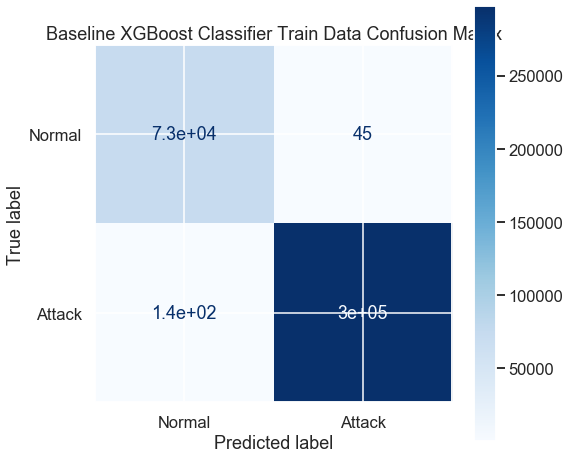


Train Data ROC Curve
---------------------------------------------------------------------------------------


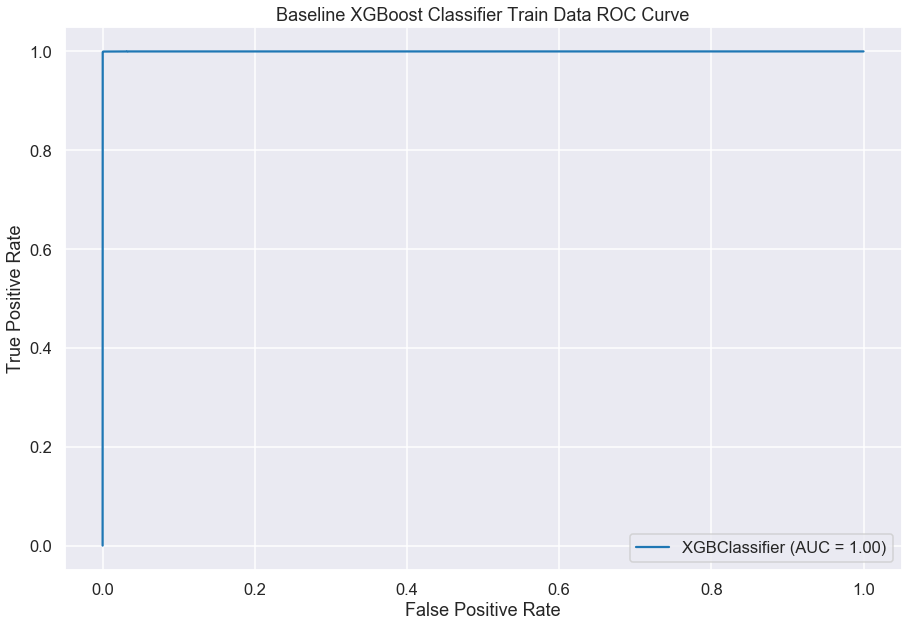


TESTING SET METRICS
--------------------------------------------------------------------------------------
Baseline XGBoost Classifier Classifier Testing Data Scores

Recall Score: 99.94%
Precision Score: 99.973%
Accuracy Score: 99.93%
F1 Score: 0.99956
ROC AUC Score: 0.99914

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


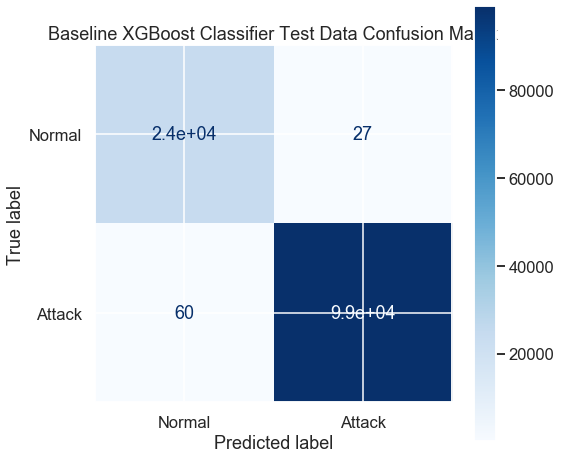


Test Data ROC Curve
---------------------------------------------------------------------------------------


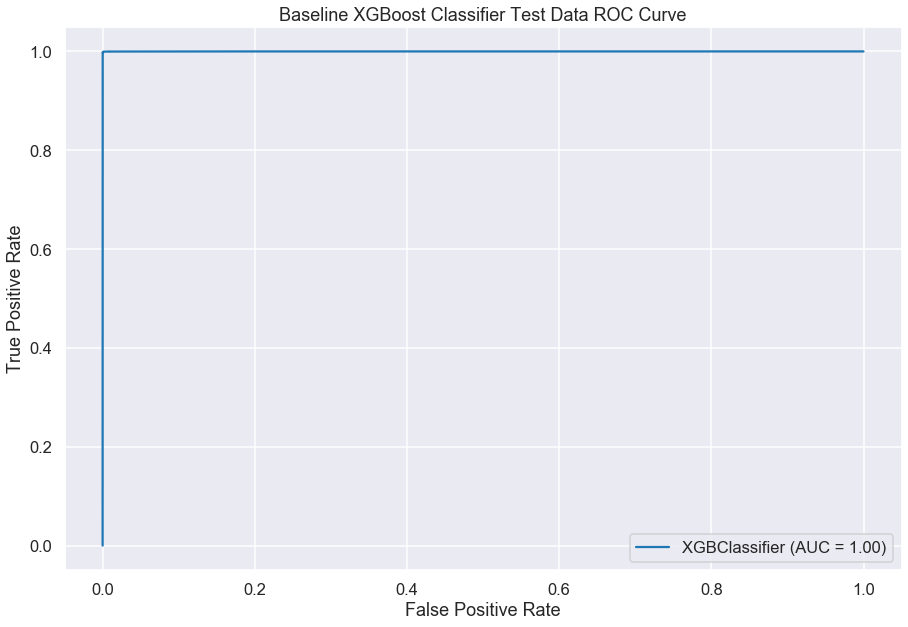

In [393]:
# evaluate classifier
binary_classification_evaluation(xgb_clf, X_train, X_val, y_train, y_val, 
                                 name_of_estimator="Baseline XGBoost Classifier",
                                 cm_labels=['Normal', 'Attack'], is_ANN=False)

## Tuned XGBoost

In [543]:
# initialize forest pipeline
xgb_pipeline = Pipeline([('xgb', xgb.XGBClassifier(random_state=42))])

# define grid parameters
xgb_grid = [{'xgb__n_estimators': [500, 1000]},
            {'xgb__learning_rate': [0.01, 0.1, 0.2]},
            # already tested max_depth, min_child_weight, subsample
            {'xgb__max_depth': [3]},
            {'xgb__min_child_weight': [1]},
            {'xgb__subsample': [1]}]

# initialize grid object
xgb_gridsearch = GridSearchCV(estimator=xgb_pipeline,
                              param_grid=xgb_grid,
                              scoring='roc_auc',
                              cv=4)

# fit to train data
xgb_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                                                      max_depth=3,
                                                      min_child_weight=1,
                                                      missing=None,
                                                      n_estimators=100,
                  

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Tuned XGBoost Classifier Classifier Training Data Scores

Recall Score: 100.0%
Precision Score: 100.0%
Accuracy Score: 100.0%
F1 Score: 1.0
ROC AUC Score: 1.0

Train Data Confusion Matrix
---------------------------------------------------------------------------------------


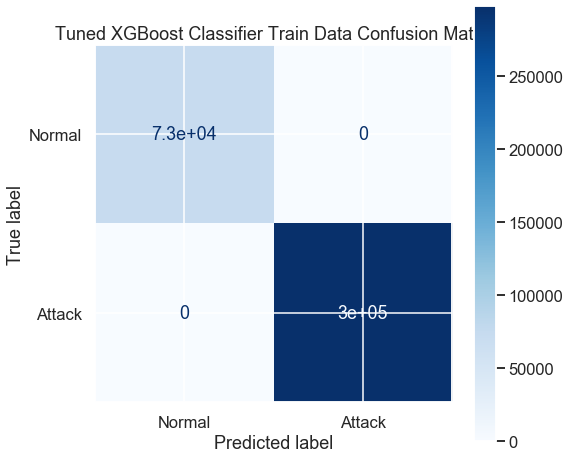


Train Data ROC Curve
---------------------------------------------------------------------------------------


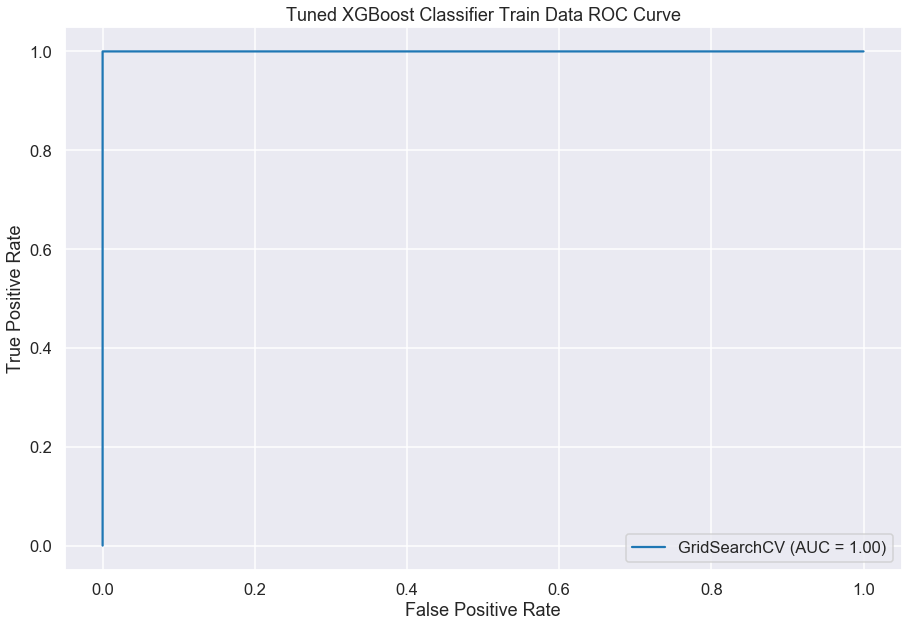


TESTING SET METRICS
--------------------------------------------------------------------------------------
Tuned XGBoost Classifier Classifier Testing Data Scores

Recall Score: 99.984%
Precision Score: 99.993%
Accuracy Score: 99.981%
F1 Score: 0.99988
ROC AUC Score: 0.99978

Test Data Confusion Matrix
---------------------------------------------------------------------------------------


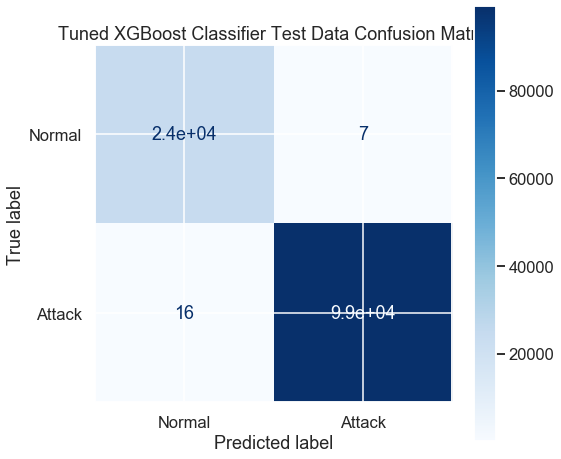


Test Data ROC Curve
---------------------------------------------------------------------------------------


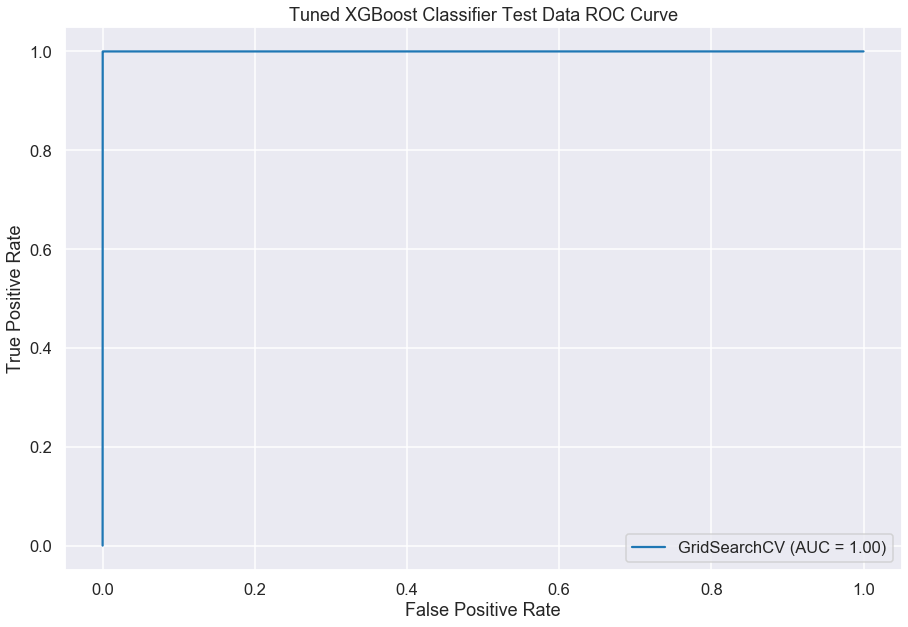

In [544]:
binary_classification_evaluation(xgb_gridsearch, X_train, X_val, y_train, y_val, 
                                 name_of_estimator="Tuned XGBoost Classifier",
                                 cm_labels=['Normal', 'Attack'], is_ANN=False)

In [545]:
# save gridsearch model
joblib.dump(xgb_gridsearch, 'xgb_gridsearch.pkl') 

['xgb_gridsearch.pkl']

Wow this just barely beat our best random forest classifier. Let's see what the best estimator was.

In [546]:
# show best estimator
xgb_gridsearch.best_estimator_

Pipeline(memory=None,
         steps=[('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=1000, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

Similar to our random forest classifier, we could continue increasing n_estimators at the hope of gaining better accuracy to seek the point of diminishing returns. However, for now we shall proceed to a neural network approach and will return to this tuning at a later time. 

I've had some issues with column names when trying to make predictions so I am going to try to fit a final classifier below using an array as an input rather than a pd dataframe. It appears Pandas and XGBoost don't get along very well. 

In [469]:
# create final xgb model using tuned hyperparameters and pass in arrays as features
xgb_final = xgb.XGBClassifier(n_estimators=1000, max_depth=3, min_child_weight=1, subsample=1, random_state=42)

# use all (train and validation) data to train; make sure to use arrays not dataframe
xgb_final.fit(train_df.values, target.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Deep Learning Model Approach

## Artificial Neural Network

We will now initialize our neural network. A few notes on our initial parameters are below.

1. We choose sixty nodes for our hidden layer because, as a rule of thumb, a good place to start is to average the number of input nodes and output nodes.
2. We will use a uniform initial weight distribution to help prevent vanishing gradient problem. Could also use normally distributed weights. 
3. For our hidden layer we will use a relu activation function, again to prevent the vanishing gradient issues associated with the sigmoid activation function. 
4. For the output layer, we will use a sigmoid function as this is a binary classification problem. 
5. We will choose Adam optimization for its performance and speed. 
6. For our loss function we will use cross entropy as this is standard for binary classification problems. 
7. We will limit our epochs to 100 to minimize training time. 

In [404]:
# initialize ANN
ann_clf = Sequential()

# create input layer and hidden layer
ann_clf.add(Dense(output_dim = 60, init = 'uniform', activation = 'relu', input_dim = 116))

# we will add a second hidden layer; accuracy declined after about 10 epochs last time
ann_clf.add(Dense(output_dim = 60, init = 'uniform', activation = 'relu'))

# we will add one more hidden layer
ann_clf.add(Dense(output_dim = 60, init = 'uniform', activation = 'relu'))

# create the output layer
ann_clf.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))

In [406]:
# assemble the ANN
ann_clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
ann_clf.fit(X_train_scaled, y_train, batch_size = 10, epochs = 10)

Epoch 1/10
370515/370515 [==============================] - 49s 132us/step - loss: 0.0075 - accuracy: 0.9989
Epoch 2/10
370515/370515 [==============================] - 48s 131us/step - loss: 0.0038 - accuracy: 0.9993
Epoch 3/10
370515/370515 [==============================] - 47s 128us/step - loss: 0.0092 - accuracy: 0.9993
Epoch 4/10
370515/370515 [==============================] - 47s 127us/step - loss: 0.0047 - accuracy: 0.9994
Epoch 5/10
370515/370515 [==============================] - 49s 133us/step - loss: 0.0035 - accuracy: 0.9993
Epoch 6/10
370515/370515 [==============================] - 48s 129us/step - loss: 0.0029 - accuracy: 0.9994
Epoch 7/10
370515/370515 [==============================] - 46s 125us/step - loss: 0.0027 - accuracy: 0.9994
Epoch 8/10
370515/370515 [==============================] - 47s 128us/step - loss: 0.0029 - accuracy: 0.9994
Epoch 9/10
370515/370515 [==============================] - 46s 125us/step - loss: 0.0026 - accuracy: 0.9994
Epoch 10/10
370515/

In [407]:
binary_classification_evaluation(ann_clf, X_train_scaled, X_val_scaled, y_train, y_val, 
                                 name_of_estimator="Baseline Neural Network",
                                 cm_labels=['Normal', 'Attack'], is_ANN=True)

TRAINING SET METRICS
--------------------------------------------------------------------------------------
Baseline Neural Network Classifier Training Data Scores

Recall Score: 99.928%
Precision Score: 99.985%
Accuracy Score: 99.93%
F1 Score: 0.99956
ROC AUC Score: 0.99932

TESTING SET METRICS
--------------------------------------------------------------------------------------
Baseline Neural Network Classifier Testing Data Scores

Recall Score: 99.902%
Precision Score: 99.982%
Accuracy Score: 99.907%
F1 Score: 0.99942
ROC AUC Score: 0.99914



# Final Model Evaluation and Comparison

Finally we will evaluate our model against completely new data. This data is even more interesting as it contains fourteen new attack types. 

## Final Models

Now we will create a list of the models we will be evaluating and zip it together with a list of model names for ease of use during of for loops later. We evaulate the following models. 

1. Logistic Regression
2. Tuned Decision Tree
3. Tuned Random Forest
4. Tuned XGBoost
5. Artificial Neural Network

In [548]:
# the final models we will be evaluating
models = [logreg_gridsearch, dt_gridsearch, forest_gridsearch, xgb_final, ann_clf]
model_names = ['logreg_gridsearch', 'dt_gridsearch', 'forest_gridsearch', 'xgb_gridsearch', 'ann_clf']
zipped_models = list(zip(models, model_names))

## The Test Set

First we will input our test data, add column names, investigate its properties, classify each attack, and add a target column. Very importantly we must make sure that the columns are congruent between the test set and train set, even after one hot encoding. 

In [410]:
# read test dataframe
test_df = pd.read_csv('corrected (1).gz', compression='gzip')
df_3 = pd.read_csv('kddcup99_csv.csv')

In [411]:
# name columns
test_df.columns = df_3.columns

Now we will write a function to classify each type of attack as we did on the training/validation data

In [412]:
# check out new function
def attack_type_2(x):
    if x in ('back.', 'land.', 'smurf.', 'pod.', 'neptune.', 'apache2.', 'udpstorm.', 'processtable.', 'mailbomb.'
             'teardrop.'):
        attack_type = 'DOS'
    elif x in ('ipsweep.', 'portsweep.', 'nmap.', 'satan.', 'saint.', 'mscan.', 'nmap.'):
        attack_type = 'Probe'
    elif x in ('loadmodule.', 'rootkit.', 'perl.', 'buffer_overflow.', 'xterm.', 'ps.', 'rootkit.', 'httptunnel.'
               'sqlattack.'):
        attack_type = 'U2R'
    elif x in ('normal.'):
        attack_type = 'NA'
    else:
        attack_type = 'R2L'
    return attack_type

In [413]:
# apply the function to the dataframe
test_df['attack_type'] = test_df['label'].apply(attack_type_2)

In [414]:
# check out distribution
test_df['attack_type'].value_counts(normalize=False)

DOS      224841
NA        60592
R2L       21361
Probe      4166
U2R          68
Name: attack_type, dtype: int64

In [415]:
# add target label
test_df['target'] = test_df['label'].apply(lambda x: 0 if x=='normal.' else 1)
test_df['target'].value_counts()

1    250436
0     60592
Name: target, dtype: int64

In [416]:
# load pickle file of test df with congruent column names
test_df_2 = pd.read_pickle('test_df_w_congruent_columns.pkl')

In [417]:
# extract target, label, and attack type from test_df
test_labels = test_df[['attack_type', 'target', 'label']]

Merge test df with congruent columns with test_labels.

In [418]:
test_df = test_df_2.merge(test_labels, left_index=True, right_index=True)

In [419]:
test_df.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised',
       ...
       'flag_RSTR', 'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF',
       'flag_SH', 'attack_type', 'target', 'label'],
      dtype='object', length=119)

In [420]:
test_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,lsu_attempted,lnum_root,lnum_file_creations,lnum_shells,lnum_access_files,lnum_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_icmp,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type,target,label
0,0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NA,0,normal.
1,0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NA,0,normal.
2,0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,R2L,1,snmpgetattack.
3,0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,R2L,1,snmpgetattack.
4,0,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,255,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,R2L,1,snmpgetattack.


## Overall Performance Comparison

First we will evaluate each model against the full test data set. 

In [509]:
# create test_df features and targets
test_df_features = test_df.drop(['attack_type', 'target', 'label'], axis=1)
test_df_targets = test_df['target']

# scale test_df features using SC
test_df_features_scaled = sc.fit_transform(test_df_features)

In [554]:
for i, model in enumerate(zipped_models):
    y_hat = np.round(model[0].predict(test_df_features_scaled),0)
    print("{} Model Performance".format(zipped_models[i][1]))
    print("--------------------------------------------")
    print("Recall Score: {}".format(recall_score(test_df_targets, y_hat)))
    print("Precision Score: {}".format(precision_score(test_df_targets, y_hat)))
    print("Accuracy Score: {}".format(accuracy_score(test_df_targets, y_hat)))
    print("F1 Score: {}".format(f1_score(test_df_targets, y_hat)))
    print("ROC AUC Score: {}".format(roc_auc_score(test_df_targets, y_hat)))
    print("")

logreg_gridsearch Model Performance
--------------------------------------------
Recall Score: 0.9169727994377805
Precision Score: 0.9938028778535107
Accuracy Score: 0.9285434108826215
F1 Score: 0.9538432143813953
ROC AUC Score: 0.9466696582348659

dt_gridsearch Model Performance
--------------------------------------------
Recall Score: 0.9555535146704148
Precision Score: 0.9290547754281211
Accuracy Score: 0.9054586725310905
F1 Score: 0.9421178508508607
ROC AUC Score: 0.8269812727827912

forest_gridsearch Model Performance
--------------------------------------------
Recall Score: 0.9110271686179303
Precision Score: 0.9931700352163257
Accuracy Score: 0.9233155857350464
F1 Score: 0.9503268708906841
ROC AUC Score: 0.9425663305460922

xgb_gridsearch Model Performance
--------------------------------------------
Recall Score: 0.9612955006468719
Precision Score: 0.9313687940793012
Accuracy Score: 0.9117989377162184
F1 Score: 0.9460955476215271
ROC AUC Score: 0.8342587880841964

ann_clf Mod

In [566]:
# import final model results csv
final_results = pd.read_csv('final_model_results.csv')
final_results

,Algorithm,Dataset,Metric,Score
0,Tuned Logistic Regression,All Attacks,Accuracy,0.92854
1,Tuned Logistic Regression,All Attacks,Recall,0.91697
2,Tuned Logistic Regression,All Attacks,Precision,0.99380
3,Tuned Logistic Regression,All Attacks,F1 Score,0.95384
4,Tuned Logistic Regression,All Attacks,ROC AUC,0.94667
5,Tuned Logistic Regression,DOS Attacks,Accuracy,0.89861
6,Tuned Logistic Regression,R2L Attacks,Accuracy,0.98624
7,Tuned Logistic Regression,U2R Attacks,Accuracy,1.00000
8,Tuned Logistic Regression,Probe Attacks,Accuracy,0.90374
9,Tuned Decision Tree,All Attacks,Accuracy,0.90546


In [567]:
# create df with just 'All Attacks' results
final_results_all = final_results[final_results['Dataset'] == 'All Attacks']

(0.5, 1)

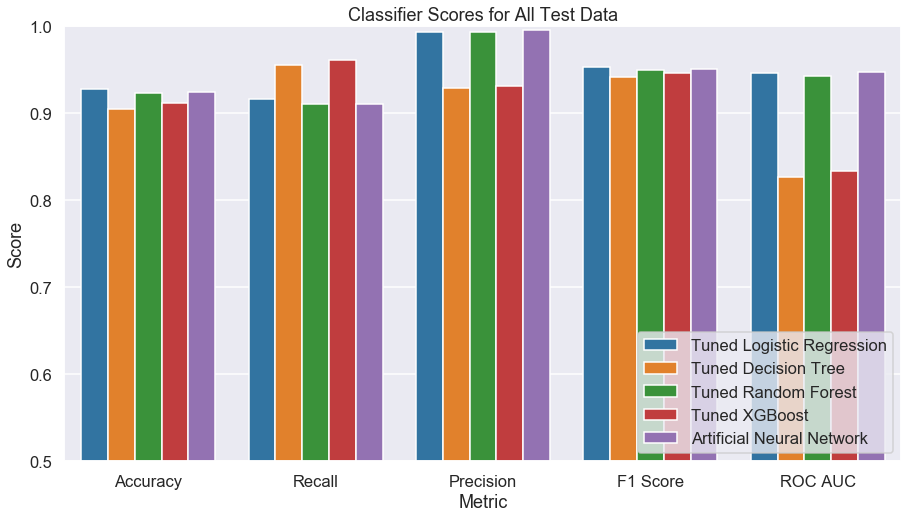

In [569]:
# plot 
plt.figure(figsize=(15,8))
ax = sns.barplot(x='Metric', y='Score', hue='Algorithm', data=final_results_all, ci=None)
plt.legend(loc='lower right')
plt.title("Classifier Scores for All Test Data")
ax.set_ylim(0.5,1)

When testing the classifiers against all attakcs there was no real standout winner across all metrics. It appears that with regards to recall the tuned decision tree and XGBoost classifiers performed decently against all types of attacks. The tuned logistic regression, random forest, and artificial neural network algorithms performed very well in the precision metric and not as well with recall. However, due to the output being a value between zero and one for the logistic regression and artificial neural networks it would be possible to adjust the threshold so that become willing to accept more false positives (normal connections identified as attacks) in exchange for less false negatives (attacks classified as normal). 

## Model Accuracy for Various Attack Types

We will now separate our dataframe into four dataframe - each with only a specific attack. We will gauge the accuracy of each model for identifying that type of attack. 

In [421]:
# create dataframe for each specific attack type
DOS_test_df = test_df[test_df['attack_type'] == 'DOS']
R2L_test_df = test_df[test_df['attack_type'] == 'R2L']
probe_test_df = test_df[test_df['attack_type'] == 'Probe']
U2R_test_df = test_df[test_df['attack_type'] == 'U2R']

Now we will create dictionaries with the features and targets of each dataframe.

In [422]:
# create target and feature arrays
frames = [DOS_test_df, R2L_test_df, probe_test_df, U2R_test_df]
frame_names = ['DOS_test_df', 'R2L_test_df', 'probe_test_df', 'U2R_test_df']
zipped_frames = list(zip(frames, frame_names))
test_sets_features = {}
test_sets_targets = {}

# iterate through list of dataframes and add features and targets to dictionaries
for i, frame in enumerate(zipped_frames):
    test_sets_features["{}_features".format(frame[1])] = frame[0].drop(['label', 'target', 'attack_type'], axis=1)
    test_sets_targets["{}_targets".format(frame[1])] = frame[0]['target']

Now we will do some data processing.

In [423]:
# transform features in each feature df
sc = StandardScaler()

for features_set in test_sets_features:
    test_sets_features[features_set] = sc.fit_transform(test_sets_features[features_set])

### DoS Attacks

For each type of attack dataframe the process will be the same. We will iterate through our models and add the resulting accuracies to a dictionary which may be referenced later. 

In [506]:
# create doc_accuracies dictionary and iterate through models list
dos_accuracies = {}
dos_features = test_sets_features['DOS_test_df_features']
dos_targets = test_sets_targets['DOS_test_df_targets']

for i, model in enumerate(zipped_models):
    y_hat = np.round(model[0].predict(dos_features),0)
    dos_accuracies['{} Accuracy'.format(model_names[i])] = accuracy_score(dos_targets, y_hat)

In [511]:
dos_accuracies

{'logreg_gridsearch Accuracy': 0.8986127974880026,
 'dt_gridsearch Accuracy': 0.9922967786124417,
 'forest_gridsearch Accuracy': 0.9918698102214454,
 'xgb_gridsearch Accuracy': 0.2631415088885034,
 'ann_clf Accuracy': 0.8498183160544562}

In [584]:
# create df with just 'DOS Attacks' results; multiple by 100 for percents plotting
final_results_dos = final_results[final_results['Dataset'] == 'DOS Attacks']
final_results_dos['Score'] = final_results_dos['Score'].apply(lambda x: 100*x)

In [610]:
final_results_dos

,Algorithm,Dataset,Metric,Score
5,Tuned Logistic Regression,DOS Attacks,Accuracy,89.861
14,Tuned Decision Tree,DOS Attacks,Accuracy,99.223
23,Tuned Random Forest,DOS Attacks,Accuracy,99.190
32,Tuned XGBoost,DOS Attacks,Accuracy,26.314
41,Artificial Neural Network,DOS Attacks,Accuracy,84.982


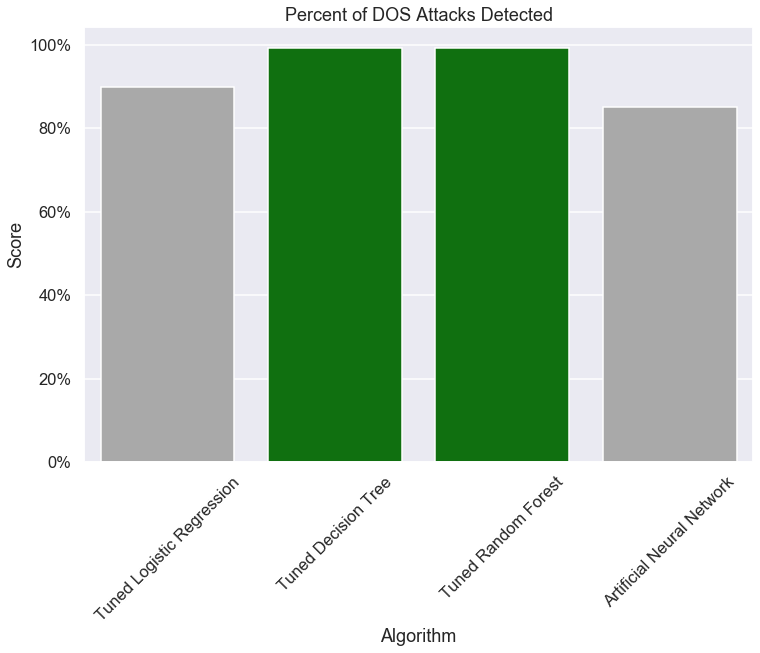

In [614]:
# plot dos accuracies

# initialize figure
plt.figure(figsize=(12,8))

# create color palette
my_pal = {algorithm: "g" if algorithm == 'Tuned Decision Tree' or 
                            algorithm == 'Tuned Random Forest' 
                         else "darkgrey" for algorithm in final_results_dos.Algorithm.unique()} 

# sns bar plot; drop tuned xgboost, something is wrong
ax = sns.barplot(x='Algorithm', y='Score', data=final_results_dos.drop(32), ci=None, palette=my_pal)

# set title, labels, color palette
plt.title("Percent of DOS Attacks Detected")
labels = final_results_dos.drop(32)['Algorithm'].unique()
ax.set_xticklabels(labels=labels, rotation=45)

# format y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

### Probe Attacks

In [522]:
# create probe_accuracies dictionary and iterate through models list
probe_accuracies = {}
probe_features = test_sets_features['probe_test_df_features']
probe_targets = test_sets_targets['probe_test_df_targets']

for i, model in enumerate(zipped_models):
    y_hat = np.round(model[0].predict(probe_features),0)
    probe_accuracies['{} Accuracy'.format(model_names[i])] = accuracy_score(probe_targets, y_hat)

In [523]:
probe_accuracies

{'logreg_gridsearch Accuracy': 0.9037445991358617,
 'dt_gridsearch Accuracy': 0.957033125300048,
 'forest_gridsearch Accuracy': 0.8358137301968315,
 'xgb_gridsearch Accuracy': 0.8442150744119059,
 'ann_clf Accuracy': 0.7518002880460873}

In [591]:
# create df with just 'Probe Attacks' results; multiple by 100 for percents plotting
final_results_probe = final_results[final_results['Dataset'] == 'Probe Attacks']
final_results_probe['Score'] = final_results_probe['Score'].apply(lambda x: 100*x)

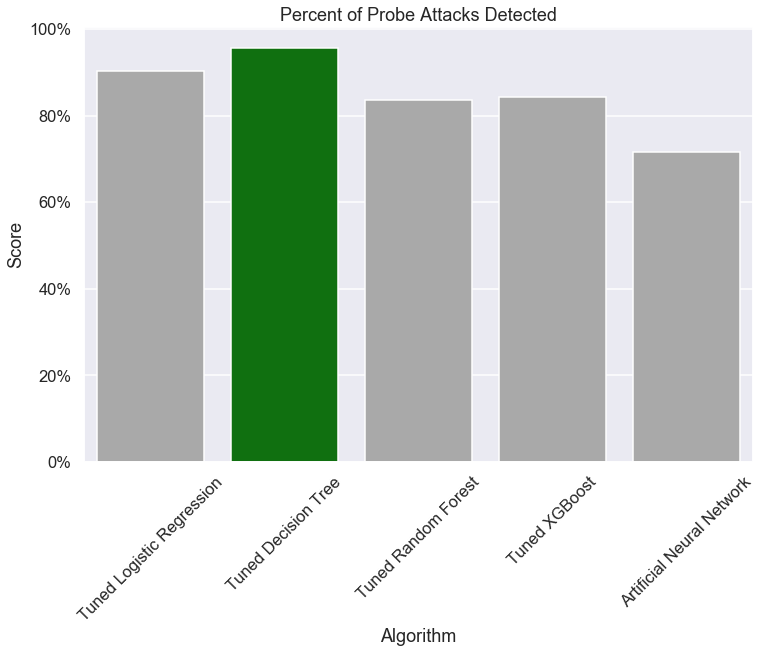

In [633]:
# plot probe accuracies

# initialize figure
plt.figure(figsize=(12,8))

# create color palette
my_pal = {algorithm: "g" if algorithm == 'Tuned Decision Tree'
                         else "darkgrey" for algorithm in final_results_probe.Algorithm.unique()} 

# sns bar plot
ax = sns.barplot(x='Algorithm', y='Score', data=final_results_probe, ci=None, palette=my_pal)

# set title, labels, color palette
plt.title("Percent of Probe Attacks Detected")
labels = final_results_probe['Algorithm'].unique()
ax.set_xticklabels(labels=labels, rotation=45)

# format y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

### R2L Attacks

In [526]:
# create R2L_accuracies dictionary and iterate through models list
R2L_accuracies = {}
R2L_features = test_sets_features['R2L_test_df_features']
R2L_targets = test_sets_targets['R2L_test_df_targets']

for i, model in enumerate(zipped_models):
    y_hat = np.round(model[0].predict(R2L_features),0)
    R2L_accuracies['{} Accuracy'.format(model_names[i])] = accuracy_score(R2L_targets, y_hat)

In [527]:
R2L_accuracies

{'logreg_gridsearch Accuracy': 0.98623659941014,
 'dt_gridsearch Accuracy': 0.5679041243387482,
 'forest_gridsearch Accuracy': 0.598239782781705,
 'xgb_gridsearch Accuracy': 0.9155938392397359,
 'ann_clf Accuracy': 0.6156546978137728}

In [594]:
# create df with just 'R2L Attacks' results; multiple by 100 for percents plotting
final_results_R2L = final_results[final_results['Dataset'] == 'R2L Attacks']
final_results_R2L['Score'] = final_results_R2L['Score'].apply(lambda x: 100*x)

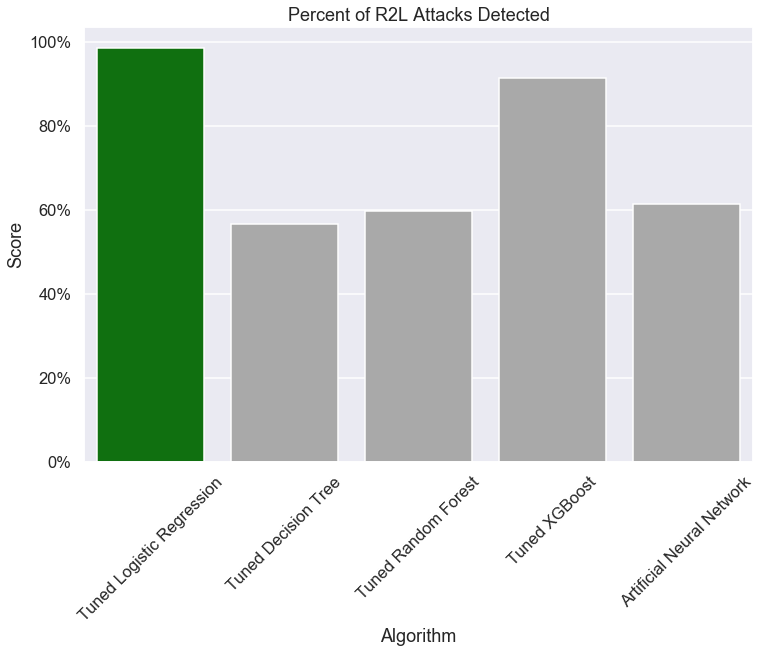

In [632]:
# plot probe accuracies

# initialize figure
plt.figure(figsize=(12,8))

# create color palette
my_pal = {algorithm: "g" if algorithm == 'Tuned Logistic Regression' 
                         else "darkgrey" for algorithm in final_results_R2L.Algorithm.unique()} 

# sns bar plot
ax = sns.barplot(x='Algorithm', y='Score', data=final_results_R2L, ci=None, palette=my_pal)

# set title, labels, color palette
plt.title("Percent of R2L Attacks Detected")
labels = final_results_R2L['Algorithm'].unique()
ax.set_xticklabels(labels=labels, rotation=45)

# format y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

### U2R Attacks

In [528]:
# create U2R_accuracies dictionary and iterate through models list
U2R_accuracies = {}
U2R_features = test_sets_features['U2R_test_df_features']
U2R_targets = test_sets_targets['U2R_test_df_targets']

for i, model in enumerate(zipped_models):
    y_hat = np.round(model[0].predict(U2R_features),0)
    U2R_accuracies['{} Accuracy'.format(model_names[i])] = accuracy_score(U2R_targets, y_hat)

In [529]:
U2R_accuracies

{'logreg_gridsearch Accuracy': 1.0,
 'dt_gridsearch Accuracy': 0.25,
 'forest_gridsearch Accuracy': 0.6470588235294118,
 'xgb_gridsearch Accuracy': 0.9705882352941176,
 'ann_clf Accuracy': 0.5588235294117647}

In [600]:
# create df with just 'R2L Attacks' results; multiple by 100 for percents plotting
final_results_U2R = final_results[final_results['Dataset'] == 'U2R Attacks']
final_results_U2R['Score'] = final_results_U2R['Score'].apply(lambda x: 100*x)

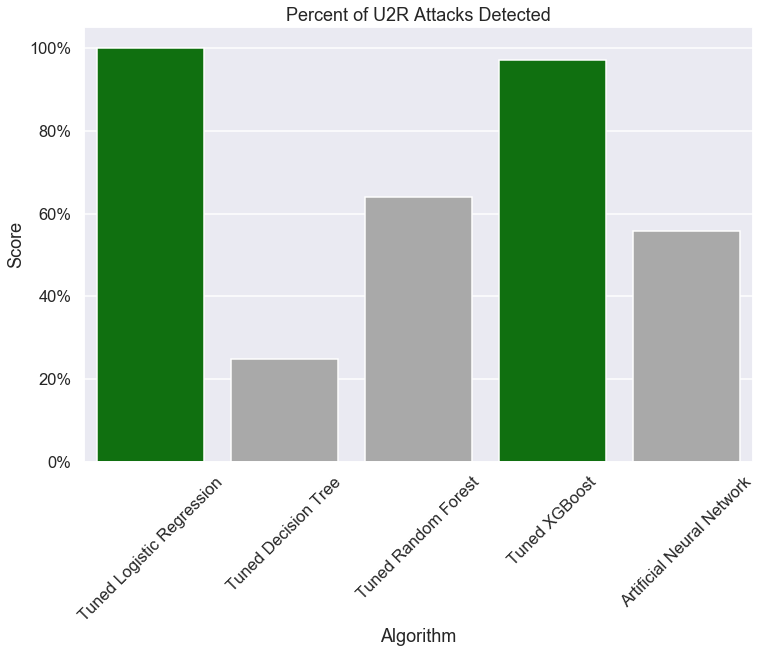

In [617]:
# plot probe accuracies

# initialize figure
plt.figure(figsize=(12,8))

# create color palette
my_pal = {algorithm: "g" if algorithm == 'Tuned XGBoost' or 
                            algorithm == 'Tuned Logistic Regression' 
                         else "darkgrey" for algorithm in final_results_U2R.Algorithm.unique()} 

# sns bar plot
ax = sns.barplot(x='Algorithm', y='Score', data=final_results_U2R, ci=None, palette=my_pal)

# set title, labels, color palette
plt.title("Percent of U2R Attacks Detected")
labels = final_results_U2R['Algorithm'].unique()
ax.set_xticklabels(labels=labels, rotation=45)

# format y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Security Recommendations and Further Studies

## Security Recommendations

### Employ Stacked Model Approach

Based on the differing performance of the models detecting various categories of attack I would recommend a stack model approach for the final ISD. For example, logistic regression and XGBoost did a great job of classifying U2R attacks, losistic regression did a great job detecting R2L attacks, and the random forest classifier did a great job detecting DOS attacks. No model did excellent (+99% detection) at detecting probe attacks so further research is necessary. 

### Employ Probabilistic Approach Where Possible

Certain alrorithms (i.e. logistic regression and ANN) output a probability of a connection belonging to a certain class. This is very beneficial as it would allow the company to fine tune their detection system and decide the threshold at which a potential attack should be flagged for analysis by a cybersecurity analyst. 

### Gather More Data on Probe Attacks

We were only able to train our models on 4,107 probe attacks so it would be high beneficial to our models to be able to to see more of these types of attacks so they may better classify them. 


## Further Studies

### Rigorous Feature Selection

Stricter feature selection would most likely allow us to train more accurate models. Because my domain knowledge in network sercurity is limited it would be difficult for me to use that for feature selection. However, other methods such as Principal Component Analysis (PCA) and correlation coefficient cutoffs could be used to determine salient features. 

### Address Class Imbalance

Out of all of our training data (494k connections) around 79% of it was DOS attacks, 19.7% were normal connections, 0.83% were probe attacks, 0.43% were R2L attacks, and 0.01% were U2R attacks. This dataset was very imbalanced from this perspective and techniques for such datasets (i.e. SMOTE) could be utilized to create a more even dataset. Furthermore, models could be individually trained to detect specific categories of attack. 

### Finer Tuning of Hyperparameters

Due to the timeframe and scale of this project there was limited time to spend tuning these models. This is especially true of the XGBoost and artificial neural network algorithms which are computationally intensive algorithms to train and have a large quantity of hyperparameters. Given more time I would like to spend more time tuning these models specifically. 

### Test Unsupervised Anomaly Detection Algorithms

Finally, I'd be interested in taking an unsupervised learning approach to detecting these intrusions. Specifically Isolation Forest and Local Outlier Factor are of personal interest and I believe could be good candiates for this job. 

# Appendix